<a href="https://colab.research.google.com/github/MichM072/ScriptieRec/blob/main/Scriptie_librec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Pip installations
import os

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

local = os.path.isdir('data/movielens_100k/ml-100k/')

if local:
    path = 'data/movielens_100k/ml-100k/'
else:
    path = '/kaggle/input/movielens-100k-dataset/ml-100k/'
#     if not os.path.isdir('/content/drive/MyDrive/ml-100k/'):
#         from google.colab import drive
#         drive.mount('/content/drive')
#         path = '/content/drive/MyDrive/ml-100k/'

if not local:
  !pip install surprise
  !pip install LibRecommender
  !pip install ray -U "ray[tune]"

/kaggle/input/movielens-100k-dataset/ml-100k/u.occupation
/kaggle/input/movielens-100k-dataset/ml-100k/u1.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.info
/kaggle/input/movielens-100k-dataset/ml-100k/u4.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.item
/kaggle/input/movielens-100k-dataset/ml-100k/README
/kaggle/input/movielens-100k-dataset/ml-100k/u1.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.data
/kaggle/input/movielens-100k-dataset/ml-100k/u5.test
/kaggle/input/movielens-100k-dataset/ml-100k/mku.sh
/kaggle/input/movielens-100k-dataset/ml-100k/u5.base
/kaggle/input/movielens-100k-dataset/ml-100k/u.user
/kaggle/input/movielens-100k-dataset/ml-100k/ub.base
/kaggle/input/movielens-100k-dataset/ml-100k/u4.base
/kaggle/input/movielens-100k-dataset/ml-100k/u2.test
/kaggle/input/movielens-100k-dataset/ml-100k/ua.base
/kaggle/input/movielens-100k-dataset/ml-100k/u3.test
/kaggle/input/movielens-100k-dataset/ml-100k/u.

In [2]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import gc
from surprise import Dataset
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.metrics import DistanceMetric
from sklearn import preprocessing
import tensorflow as tf

In [3]:
user_cols = ['userId',  'age',  'gender',  'occupation',  'zip code']
user_data = pd.read_csv(path + 'u.user', sep='|', names=user_cols)

rating_cols = ['userId' , 'itemId','rating', 'timestamp']
rating_matrix = pd.read_csv(path + 'u.data', sep='\t', names=rating_cols).sort_values(by='userId', ascending=True).reset_index(drop=True)

item_cols = ['itemId', 'movieTitle', 'releaseDate', 'videoReleaseDate', 
        'IMDb-URL', 'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
        'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror',
        'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
item_matrix = pd.read_csv(path + 'u.item', sep='|', names = item_cols, encoding = 'unicode_escape', engine ='python')

In [4]:
df_data = rating_matrix.merge(user_data, on='userId').merge(item_matrix, on='itemId')

df_data.head()

,userId,itemId,rating,timestamp,age,gender,occupation,zip code,movieTitle,releaseDate,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,55,5,875072688,24,M,technician,85711,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
1,8,55,5,879362286,36,M,administrator,05201,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
2,16,55,5,877717956,21,M,entertainment,10309,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
3,23,55,4,874785624,30,F,artist,48197,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
4,24,55,5,875323308,21,F,artist,94533,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0


In [5]:
day_split = 86400

from libreco.data import random_split

df_data = df_data.rename(columns = {'userId': 'user', 'itemId' : 'item', 'rating': 'label', 'timestamp': 'time'})

# df_data2

# split data into three folds for training, evaluating and testing
# first_half_data = df_data[: (len(df_data) // 2)]
train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1], seed=42)

In [6]:
from libreco.data import DatasetPure

# sparse_col = ["gender", "occupation", "zip code", 
#               'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
# dense_col = ["age"]
# user_col = ['age', 'gender', 'occupation', 'zip code']
# item_col = ['unknown', 'Action', 'Adventure', 'Animation', 'Children\'s',
#               'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir',
#               'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)

In [7]:
from libreco.algorithms import SVD
from libreco.evaluation import evaluate

In [8]:
# import itertools

# test_grid = {
#     'epochs' : [10, 20, 30],
#     'reg' : [2, 4]
# }

# # print(list(test_grid.keys()))
# # allNames = sorted(test_grid)
# # print(allNames)
# # combinations = itertools.product(*(test_grid[Name] for Name in allNames))
# # print(list(combinations))

# keys, values = zip(*test_grid.items())
# permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

# for combination in permutations_dicts:
#   for key in combination:
#     print(combination[key])
#   print(combination)

In [9]:
# import copy

# def gridsearch(model, param_grid, **kwargs):

#   target_model = model

#   best_config = []
#   best_eval = 1000

#   keys, values = zip(*param_grid.items())
#   combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

#   for configuration in combinations:

#     # reset graph
#     tf.compat.v1.reset_default_graph()

#     # Initialize estimator model
#     est = target_model(**kwargs)

#     pre_reg_conf = copy.copy(configuration)

#     for attribute in configuration:
#       if attribute == 'reg' and attribute is not None:
#         configuration[attribute] = tf.keras.regularizers.l2(configuration[attribute])
#       setattr(est, attribute, configuration[attribute])

#     print(f'Configuration completed, training: {target_model.__name__}')
#     print(f'Current configuration: {pre_reg_conf}')

#     with tf.device('/GPU:0'):

#       est.fit(
#           train_data,
#           verbose=0,
#           shuffle=True,
#       )

#     evaluation = evaluate(model=est, data=eval_data, metrics=["rmse"])
#     if evaluation['rmse'] < best_eval:
#       best_eval = evaluation['rmse']
#       best_config = configuration

#   return (best_config, best_eval)

In [10]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10],
#     'reg': [0.2],
#     'lr': [0.004],
#     'embed_size': [10, 100]
# }

# defaults = {'task': 'ranking',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# gridsearch(SVD, param_grid, task="rating",
#     data_info=data_info,
#     loss_type="cross_entropy",
#     lr=1e-3,
#     batch_size=2048)

In [12]:
# for reg in [None, 0.000002, 0.00002, 0.0002, 0.002, 0.02]:
#   tf.compat.v1.reset_default_graph()
#   model = SVD(
#     task="rating",
#     data_info=data_info,
#     n_epochs=1,
#     loss_type="cross_entropy",
#     lr=0.03,
#     reg=reg,
#     batch_size=2048,
# )
#   model.fit(
#       train_data,
#       verbose=2,
#       shuffle=True,
#       eval_data=eval_data,
#       metrics=['rmse'],
#   )

In [13]:
# tf.compat.v1.reset_default_graph()

# model = SVD(
#     task="rating",
#     data_info=data_info,
#     embed_size = 100,
#     n_epochs=20,
#     loss_type="cross_entropy",
#     lr = 0.001,
#     reg = 0.02,
#     batch_size=2048,
# )

# model.fit(
#     train_data,
#     verbose=0,
#     shuffle=True,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# model.get_item_embedding(1)

In [14]:
from libreco.evaluation import evaluate
# evaluate(model=model, data=test_data, metrics=['rmse'])

In [15]:
from libreco.algorithms import (
    ALS,
    SVD,
    ItemCF,
    SVDpp,
    UserCF,
)

In [16]:
# def create_regs(regs):
#   regulators = [tf.keras.regularizers.l2(reg) for reg in regs]
#   regulators.append(None)
#   return regulators

In [17]:
!pip install hpbandster ConfigSpace
!pip install statsmodels --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 45.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 kB 6.4 MB/s eta 0:00:00
  Created wheel for hpbandster: filename=hpbandster-0.7.4-py3-none-any.whl size=80008 sha256=0d4a0f334d492ae77d4431865bcacf23bbf056e93c6e7efb3fd64648b6b6257d
  Stored in directory: /root/.cache/pip/wheels/59/5d/ae/de6975c9d67f502599f0a1ba89d0794c8692d0e73a57f2a3ea
Successfully built hpbandster


In [18]:
from ray import tune, air
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB
from ray.air import session
import ConfigSpace as CS

In [19]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

# Hyper parameter optimalisation!

In [20]:
from IPython.display import clear_output

In [21]:
def svd_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svd = SVD(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svd, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svd_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5, "accelator": 1}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    result = svd_tuner.fit()
    return result.get_best_result().config

In [22]:
# svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run = svd_tuner(train_data, eval_data, data_info, svd_search)

In [23]:
# print(very_nice_test_run.get_best_result().config)

In [24]:
# svd_tuner.get_results().get_best_result()

In [25]:
def svdpp_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      svdpp = SVDpp(
          "rating",
          data_info,
          loss_type="cross_entropy",
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          lr=config['lr'],
          reg=config['reg'],
          batch_size=256,
      )
      svdpp.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=2)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    svdpp_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return svdpp_tuner.fit().get_best_result().config

In [26]:
# svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#         'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#         'reg': tune.choice([1e-4, 2e-4, 3e-4]),
#         'embed_size': tune.choice([10, 20, 50, 75, 100])}

# very_nice_test_run2 = svdpp_tuner(train_data, eval_data, data_info, svdpp_search)

In [27]:
# svdpp_tuner.get_results().get_best_result()

In [28]:
def als_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      als = ALS(
          "rating",
          data_info,
          embed_size=config['embed_size'],
          n_epochs=config['n_epochs'],
          reg=config['reg'],
      )
      als.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False,
      )
      clear_output(wait=False)
      accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    als_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return als_tuner.fit().get_best_result().config

In [29]:
# als_tuner.get_results().get_best_result()

In [30]:
# tf.compat.v1.reset_default_graph()
# als = ALS(
#     "rating",
#     data_info,
#     embed_size=10,
#     n_epochs=100,
#     reg=5.0,
# )
# als.fit(
#   train_data,
#   verbose=2,
#   shuffle=True,
# )
# accuracy = evaluate(model=als, data=eval_data, metrics=['rmse'])

# print(accuracy)

In [31]:
# tf.compat.v1.reset_default_graph()
# user_cf = UserCF(
#     "rating",
#     data_info,
#     sim_type='cosine',
#     k_sim=25,
# )
# user_cf.fit(
#   train_data,
#   verbose=0,
# )
# accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'])
# acc = accuracy['rmse']

In [32]:
# print(acc)

In [33]:
def item_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      item_cf = ItemCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=item_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    item_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return item_cf_tuner.fit().get_best_result().config

In [34]:
# print("Best hyperparameters found were: ", item_cf_results.get_best_result().config)
# item_cf_tuner.get_results().get_best_result()

In [35]:
def user_cf_tuner(train_data, eval_data, data_info, search_space, samples=10):
    def objective(config):
      tf.compat.v1.reset_default_graph()
      user_cf = UserCF(
          "rating",
          data_info,
          sim_type=config['sim_type'],
          k_sim=config['k_sim'],
      )
      user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
      )
      accuracy = evaluate(model=user_cf, data=eval_data, metrics=['rmse'], neg_sampling=False)
      acc = accuracy['rmse']
      return {"rmse": acc}

    search_space = search_space

    Bhob = TuneBOHB()
    Bhob = tune.search.ConcurrencyLimiter(Bhob, max_concurrent=4)
    scheduler = HyperBandForBOHB(
        time_attr="training_iteration",
        max_t=100,
        reduction_factor=4,
        stop_last_trials=False,
    )

    user_cf_tuner = tune.Tuner(
        tune.with_resources(
            objective, resources={"cpu": 2, "gpu": 0.5}
        ),
        # objective,
        tune_config=tune.TuneConfig(
            metric="rmse",
            mode="min",
            search_alg=Bhob,
            num_samples=samples,
            scheduler=scheduler,
        ),
            run_config=air.RunConfig(
            name="bohb_exp",
            stop={"training_iteration": 100},
        ),
        param_space=search_space,
    )
    return user_cf_tuner.fit().get_best_result().config

In [36]:
# print("Best hyperparameters found were: ", user_cf_results.get_best_result().config)
# user_cf_tuner.get_results().get_best_result()

In [37]:
# tf.compat.v1.reset_default_graph()

# model_1 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
#     lower_upper_bound = (0,5)
# )

# model_1.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )

# accuracy_m1 = evaluate(model=model_1, data=test_data, metrics=['rmse'])

In [38]:
# tf.compat.v1.reset_default_graph()

# model_2 = ALS(
#     task="rating",
#     data_info=data_info,
#     embed_size = 10,
#     n_epochs=200,
#     reg = 7.0,
# )

# model_2.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     eval_data=eval_data,
#     metrics=["msre"],
# )
# accuracy_m2 = evaluate(model=model_2, data=test_data, metrics=['rmse'])

In [39]:
# print(accuracy_m1, accuracy_m2)

In [40]:
# !zip -r root.zip /root/ 

In [41]:
# def objective(config):
#   tf.compat.v1.reset_default_graph()
#   svdpp = SVDpp(
#       "rating",
#       data_info,
#       loss_type="cross_entropy",
#       embed_size=config['embed_size'],
#       n_epochs=config['n_epochs'],
#       lr=config['lr'],
#       reg=config['reg'],
#       batch_size=256,
#   )
#   svdpp.fit(
#     train_data,
#     verbose=2,
#     shuffle=True,
#     neg_sampling = False,
#   )
#   accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'], neg_sampling=False)
#   acc = accuracy['rmse']
#   return {"rmse": acc}

# search_space = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
#     'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
#     'reg': tune.choice([None, 1e-4, 2e-4, 3e-4]),
#     'embed_size': tune.choice([10, 20, 50, 75, 100])}

# algo = HyperOptSearch()

# svdpp_tuner = tune.Tuner(
#     objective,
#     tune_config=tune.TuneConfig(
#         metric="rmse",
#         mode="min",
#         search_alg=algo,
#         num_samples=20,
#     ),
#     param_space=search_space,
# )
# svdpp_test_results = svdpp_tuner.fit()

In [42]:
# svdpp_test_results.get_best_result()

In [43]:
# tf.compat.v1.reset_default_graph()

# param_grid = {
#     'n_epochs': [10, 25, 50, 75, 100],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# param_grid2 = {
#     'n_epochs': [10, 25, 50],
#     'lr': [1e-3, 2e-3, 3e-3, 4e-3],
#     'regs': [0.03, 0.04, 0.05],
#     'embed_size': [10, 20, 50, 75, 100]
# }

# defaults = {'task': 'rating',
#             'data_info':data_info, 
#             'loss_type': "cross_entropy", 
#             'lr':1e-04, 
#             'batch_size':2048}

# performance = []


# config, eval = gridsearch(SVD, param_grid, task="rating",
#       data_info=data_info)
# print(f'Finished {model}')
# result = ('SVD', config, eval)
# performance.append(result)
# print('Fully finished!')

In [44]:
# print(performance)

In [45]:
df_data.head()

,user,item,label,time,age,gender,occupation,zip code,movieTitle,releaseDate,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,55,5,875072688,24,M,technician,85711,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
1,8,55,5,879362286,36,M,administrator,05201,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
2,16,55,5,877717956,21,M,entertainment,10309,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
3,23,55,4,874785624,30,F,artist,48197,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0
4,24,55,5,875323308,21,F,artist,94533,"Professional, The (1994)",01-Jan-1994,...,0,0,0,0,0,1,0,1,0,0


In [46]:
from libreco.data import split_by_num_chrono

def create_timesets(data, increments = 1, test_num = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    temp_data = data.loc[data['time'] <= train_days]

    train_set, test_set = split_by_num_chrono(temp_data, test_size=test_num)

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [47]:
train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 4)

print(train[3]['user'].isin(test[3]['user']).value_counts())

True     16041
False      472
Name: user, dtype: int64


In [48]:
def create_timesets2(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

  train_days = df_data.time.min()
  day_split = 86400 # day in seconds
  train_sets = [] # list of train_set datasets
  test_sets = [] # list of test_sets
  temporal_data = [] # keep track of how many days have been trained on.

  if stop == None:
    stop = df_data.time.max()
  else:
    stop = train_days + day_split * increments * stop

  while train_days < stop:
    train_days = train_days + day_split * increments

    train_set = data.loc[data['time'] <= train_days]
    test_set = data.loc[(data['time'] > train_days) & (data['time'] <= train_days + day_split * test_days)]

    test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
    train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

    train_sets.append(train_set)
    test_sets.append(test_set)

    temp_time = train_days - df_data.time.min()
    temporal_data.append(temp_time)

  return train_sets, test_sets, temporal_data

In [49]:
from libreco.data import split_by_ratio_chrono
def create_timesets3(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

    train_days = df_data.time.min()
    day_split = 86400 # day in seconds
    train_sets = [] # list of train_set datasets
    test_sets = [] # list of test_sets
    eval_sets = []
    temporal_data = [] # keep track of how many days have been trained on.

    if stop == None:
        stop = df_data.time.max()
    else:
        stop = train_days + day_split * increments * stop

    while train_days + day_split * (increments + test_days) <= stop:
        train_days = train_days + day_split * increments

        test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
        train_set = data.loc[data['time'] <= train_days]

        if make_eval:
            train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
            eval_sets.append(eval_set)

        test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

        train_sets.append(train_set)
        test_sets.append(test_set)

        temp_time = train_days - df_data.time.min()
        temporal_data.append(temp_time)
    
    if make_eval:
        return train_sets, test_sets, eval_sets, temporal_data
    
    return train_sets, test_sets, temporal_data

In [50]:
# from libreco.data import split_by_ratio_chrono
# def make_chrono_split(data, increments = 1, test_days = 1, stop = None, ignore_remainder = True, make_eval=False, eval_size=0.2):

#     train_days = df_data.time.min()
#     day_split = 86400 # day in seconds
#     train_sets = [] # list of train_set datasets
#     test_sets = [] # list of test_sets
#     eval_sets = []
#     temporal_data = [] # keep track of how many days have been trained on.

#     if stop == None:
#         stop = df_data.time.max()
#     else:
#         stop = train_days + day_split * increments * stop

#     while train_days + day_split * (increments + test_days) <= stop:
#         train_days = train_days + day_split * increments

#         test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
#         train_set = data.loc[data['time'] <= train_days]

#         if make_eval:
#             train_set, eval_set = split_by_ratio_chrono(train_set, test_size = eval_size)
#             eval_sets.append(eval_set)

#         test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

#         train_sets.append(train_set)
#         test_sets.append(test_set)

#         temp_time = train_days - df_data.time.min()
#         temporal_data.append(temp_time)
    
#     if make_eval:
#         return train_sets, test_sets, eval_sets, temporal_data
    
#     return train_sets, test_sets, temporal_data

In [51]:
# train, test, temppp = create_timesets3(df_data, increments=10, test_days = 1, stop = 4)

# print(test[3]['user'].isin(train[3]['user']).value_counts())

In [52]:
# accuracy = []
# epochs = []

# for epoch in [10, 15, 25, 50, 75, 100]:
#     epochs.append(epoch)
#     tf.compat.v1.reset_default_graph()
#     svdpp = SVDpp(
#           "rating",
#           data_info,
#           loss_type="cross_entropy",
#           embed_size=20,
#           n_epochs=epoch,
#           lr=0.0001,
#           reg=0.01,
#           batch_size=256,
#       )
#     svdpp.fit(
#         train_data,
#         verbose=-1,
#         shuffle=False,
#       )
    
#     accuracy.append(evaluate(model=svdpp, data=eval_data, metrics=['rmse'])['rmse'])

# fig, ax = plt.subplots()

# ax.plot(epochs, accuracy, label=f'{epoch}')

# ax.set(xlabel=f'epoch {epoch}', ylabel=f'accuracy',
#       title=f'Comparison for {epoch}')
# ax.grid()
# #     ax.set_xticks(ax.get_xticks()[::])

# # fig.savefig("test.png")
# plt.legend()
# plt.show()

In [53]:
# accuracy = evaluate(model=svdpp, data=eval_data, metrics=['rmse'])

# accuracy.values()

In [54]:
# total_precision = 0

# for user in np.unique(test_data.user_indices):
#     print(user)
    

In [55]:
# train, test, temppp = create_timesets(df_data, increments=10, test_num = 1, stop = 5)

# for temp in temppp:
#   print(temp / 86400)

In [56]:
# for tr, te in zip(train, test):
#   print(tr.shape)
#   print(te.shape)

In [57]:
# kaas1, kaas2 = split_by_num_chrono(df_data, test_size = 1)
# kaas1, data_kaas = DatasetPure.build_trainset(kaas1)
# kaas2 = DatasetPure.build_testset(kaas2)

# for user in kaas1.user_indices:
#   if user not in kaas2.user_indices:
#     print(user)

In [58]:
import matplotlib.pyplot as plt

In [59]:
test = {'Day 1': {'SVD': {'precision': 0.09759825327510918, 'recall': 0.11243680555691093, 'map': 0.2329821183082646, 'ndcg': 0.32328197069467746}, 'SVDpp': {'precision': 0.09574235807860262, 'recall': 0.11352322985020856, 'map': 0.23240755181257364, 'ndcg': 0.3232181370376707}, 'ItemCF': {'precision': 0.030895196506550218, 'recall': 0.04874355087375927, 'map': 0.0974498336452485, 'ndcg': 0.13003226035468538}, 'UserCF': {'precision': 0.0027292576419213977, 'recall': 0.0021887008976569536, 'map': 0.006925816177999584, 'ndcg': 0.011535077285933745}, 'ALS': {'precision': 0.12827510917030568, 'recall': 0.18282404703448726, 'map': 0.2724576243039671, 'ndcg': 0.38393204203985315}}}



In [60]:
def model_results(results, metrics, nth_ticks=2):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig("test.png")
    plt.legend()
    plt.show()

In [61]:
def check_sim(train, test):
  print(train['user'].isin(test['user']).value_counts())
  print(test['user'].isin(train['user']).value_counts())

In [62]:
import time as t

In [63]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):

  results = {}

  for algo in algos:
    print(algo)
    result = evaluate(model=algo, data=test_data, metrics=metrics)
    results[algo.__class__.__name__] = result

  return results

def run_experiment(data, increments, test_days, stop, ignore_remainder = True, task = 'ranking'):

  metrics_rating = [
      "rmse"
  ]

  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

  if task == 'ranking':
    metrics = metrics_ranking
  else:
    metrics = metrics_rating

  train, test, temporal_data = create_timesets(data, increments, test_days, stop, ignore_remainder)

  temporal_results = {}

  i = 0

  for train, test in zip(train, test):

    # print('testing')

    # print('########## CHECKING SIM ###########')
    # print('########## train users in test set ##########')
    # print(train['user'].isin(test['user']).value_counts())
    # print('########## test users in train set ##########')
    # print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)
    test_data = DatasetPure.build_testset(test)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=20,
        n_epochs=50,
        lr=0.001,
        reg=0.0001,
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
    )

    svd_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=50,
        n_epochs=25,
        lr=0.001,
        reg=0.0001,
    )

    svdpp.fit(
        train_data,
        verbose=0,
    )

    svdpp_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=25,
        sim_type="cosine",
    )

    item_cf.fit(
        train_data,
        verbose=0
    )

    item_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=50,
        sim_type="cosine",
    )

    user_cf.fit(
        train_data,
        verbose=0,
    )

    user_cf_time = t.perf_counter() - start

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=10,
        n_epochs=200,
        reg=5.0
    )

    als.fit(
        train_data,
        verbose=0,
    )

    als_time = t.perf_counter() - start

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    time = int(temporal_data[i] / 86400)

    temporal_results[str(time)] = create_results(algos, test_data, metrics)

    for times in timers:
      temporal_results[str(time)][times[0]]['train_time'] = times[1]

    i+=1

  return temporal_results


In [64]:
# test_run44 = run_experiment(df_data, 10, 1, 1, ignore_remainder = True, task = 'rating')

# print(test_run44)

In [65]:
# test_run = run_experiment(df_data, 10, 1, None, ignore_remainder = True, task = 'rating')

# print(test_run)

In [66]:
def model_results(results, metrics, nth_ticks=2, model_time=False):
  time_iter = list(results.keys())
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  if model_time:
    metrics.append('train_time')

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = []
      for time in time_iter:
        value_list.append(results[time][algo][metric])

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::nth_ticks])

    fig.savefig(f"{metric}.png")
    plt.legend()
    plt.show()

In [67]:
# test_figures = model_results(test_run, ['rmse'])

In [68]:
# test_1 = {'test': 1, 'test2': 2}
# test_12 = {'test': 1, 'test2': 2}

# test_2 = {}
# test_2['test_3'] = test_1
# test_2['test_5'] = test_12

# test_4 = {}

# test_4['test_6'] = test_2

# print(test_4)

# for item in test_4.values():
#   print(item)

In [69]:
  metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
  ]

# test_run2 = run_experiment(df_data, 5, 5, None, ignore_remainder = True, task = 'ranking')
# test_figures2 = model_results(test_run2, metrics_ranking, 4)

In [70]:
def model_results_regular(results, metrics):
  algorithms = list(results[time_iter[0]].keys())

  plt.figure(figsize=(10,6))

  for metric in metrics:

    fig, ax = plt.subplots()
    
    for algo in algorithms:
      value_list = [results[algo][metric]]

      ax.plot(time_iter, value_list, label=f'{algo}')

    ax.set(xlabel='time (d)', ylabel=f'{metric}',
          title=f'Comparison for {metric}')
    ax.grid()
    ax.set_xticks(ax.get_xticks()[::2])

    # fig.savefig("test.png")
    plt.legend()
    plt.show()

In [71]:
# def create_timesets3(train, test, increments = 1, test_days = 1, stop = None, ignore_remainder = True):

#   train_days = df_data.time.min()
#   day_split = 86400 # day in seconds
#   train_sets = [] # list of train_set datasets
#   test_sets = [] # list of test_sets
#   temporal_data = [] # keep track of how many days have been trained on.

#   if stop == None:
#     stop = df_data.time.max()
#   else:
#     stop = train_days + day_split * increments * stop

#   while train_days < stop:
#     train_days = train_days + day_split * increments

#     train_set = train.loc[train['time'] <= train_days]
#     test_set = test.loc[(test['time'] > train_days) & (test['time'] <= train_days + day_split * test_days)]

#     test_set = test_set.loc[test_set['user'].isin(train_set['user'])]
#     train_set = train_set.loc[train_set['user'].isin(test_set['user'])]

#     train_sets.append(train_set)
#     test_sets.append(test_set)

#     temp_time = train_days - df_data.time.min()
#     temporal_data.append(temp_time)

#   return train_sets, test_sets, temporal_data

In [72]:
from libreco.data import split_by_ratio_chrono

In [73]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        print(algo)
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        results[algo.__class__.__name__] = result

    return results

def run_experiment_alt(data, increments, test_days, stop, search_spaces, ignore_remainder = True, task = 'ranking', eval_size=0.2, samples=10, tune=False):

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]

    if task == 'ranking':
        metrics = metrics_ranking
    else:
        metrics = metrics_rating
    
    if tune:
        train, test, eval, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder, make_eval=True, eval_size=eval_size)
    else: 
        train, test, temporal_data = create_timesets3(data, increments, test_days, stop, ignore_remainder)

    temporal_results = {}

    i = 0

    for train, test in zip(train, test):
        
        time = int(temporal_data[i] / 86400)

        print("\n", "=" * 30, time, "=" * 30)

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

        train_data, data_info = DatasetPure.build_trainset(train)
        
        if tune:
            eval_data = DatasetPure.build_evalset(eval[i])
    
        test_data = DatasetPure.build_testset(test)
        
        svd_params = {
            'embed_size': 20,
            'n_epochs': 50,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

        start = t.perf_counter()

        reset_state("SVD")
        svd = SVD(
            task,
            data_info,
            embed_size=svd_params['embed_size'],
            n_epochs=svd_params['n_epochs'],
            lr=svd_params['lr'],
            reg=svd_params['reg'],
        )

        svd.fit(
            train_data,
            verbose=0,
            shuffle=False,
            neg_sampling=False
        )

        svd_time = t.perf_counter() - start
        
        svdpp_params = {
            'embed_size': 50,
            'n_epochs': 25,
            'lr': 0.001,
            'reg': 0.0001
        }
        
        if tune:
            svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

        start = t.perf_counter()

        reset_state("SVD++")
        svdpp = SVDpp(
            task,
            data_info,
            loss_type="cross_entropy",
            embed_size=svdpp_params['embed_size'],
            n_epochs=svdpp_params['n_epochs'],
            lr=svdpp_params['lr'],
            reg=svdpp_params['reg'],
        )

        svdpp.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        svdpp_time = t.perf_counter() - start
        
        item_cf_params = {
            'k_sim': 25,
            'sim_type': 'cosine'
        }
        
        if tune:
            item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

        start = t.perf_counter()

        reset_state("item_cf")
        item_cf = ItemCF(
            task,
            data_info=data_info,
            k_sim=item_cf_params['k_sim'],
            sim_type=item_cf_params['sim_type'],
        )

        item_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        item_cf_time = t.perf_counter() - start
        
        user_cf_params = {
            'k_sim': 50,
            'sim_type': 'cosine'
        }
        
        if tune:
            user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

        start = t.perf_counter()

        reset_state("user_cf")
        user_cf = UserCF(
            task,
            data_info=data_info,
            k_sim=user_cf_params['k_sim'],
            sim_type=user_cf_params['sim_type'],
        )

        user_cf.fit(
            train_data,
            verbose=0,
            neg_sampling=False,
        )

        user_cf_time = t.perf_counter() - start
        
        als_params = {
            'embed_size': 10,
            'n_epochs': 200,
            'reg': 5.0
        }
        
        if tune:
            als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

        start = t.perf_counter()

        reset_state("ALS")
        als = ALS(
            task,
            data_info,
            embed_size=als_params['embed_size'],
            n_epochs=als_params['n_epochs'],
            reg=als_params['reg']
        )

        als.fit(
            train_data,
            verbose=0,
            neg_sampling=False
        )

        als_time = t.perf_counter() - start

        timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

        algos = [svd, svdpp, item_cf, user_cf, als]

        temporal_results[str(time)] = create_results(algos, test_data, metrics)

        for times in timers:
            temporal_results[str(time)][times[0]]['train_time'] = times[1]

        i+=1

    return temporal_results


# Main Testing!

In [74]:
# Tuning settings

svd_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

svdpp_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100]),
        'lr': tune.choice([1e-3, 2e-3, 3e-3, 4e-3]),
        'reg': tune.choice([1e-4, 2e-4, 3e-4]),
        'embed_size': tune.choice([10, 20, 50, 75, 100])}

als_search = {'n_epochs': tune.choice([10, 25, 50, 75, 100, 150, 200]),
        'reg': tune.quniform(3.0, 20.0, 1.0),
        'embed_size': tune.choice([10, 20, 50, 75, 100, 150, 200])}

item_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

user_cf_search = {'sim_type': tune.choice(['pearson', 'cosine']),
                    'k_sim': tune.choice([10, 25, 50, 75, 100])}

In [75]:
# metrics_ranking = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# metrics_rating = ['rmse']

# search_spaces = {
#     'svd': svd_search,
#     'svdpp': svdpp_search,
#     'item_cf': item_cf_search,
#     'user_cf': user_cf_search,
#     'als': als_search
# }

# test_run4 = run_experiment_alt(df_data, 20, 1, search_spaces = search_spaces, stop=None, task='rating', eval_size=0.2, samples=10, tune=True)
# test_figures4 = model_results(test_run4, metrics_rating, 2, model_time=True)

In [76]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        test_time_start = t.perf_counter()
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        result['test_time'] = t.perf_counter() - test_time_start
        results[algo.__class__.__name__] = result

    return results

def run_experiment_chrono(data, search_spaces, split, save=True, experiment_name = 'default', task = 'ranking', treshold = 4, samples=10, tune=False):
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    if tune:
        assert len(split) == 3, f'Tuning is set to True, expected split with 3 values, got {len(split)}'
        train, eval, test = split_by_ratio_chrono(experiment_data, order=True, multi_ratios=split)
    else: 
        if len(split) == 3:
            print(f'Tune is set to False, but split contains 3 values, combining values:')
            split = [split[0], split[1] + split[2]]
            print(f'New split: {split}')
        train, test, = split_by_ratio_chrono(experiment_data, order=True, test_size=split[1])

    #     print('testing')

    #     print('########## CHECKING SIM ###########')
    #     print('########## train users in test set ##########')
    #     print(train['user'].isin(test['user']).value_counts())
    #     print('########## test users in train set ##########')
    #     print(test['user'].isin(train['user']).value_counts())

    train_data, data_info = DatasetPure.build_trainset(train)

    if tune:
        eval_data = DatasetPure.build_evalset(eval)

    test_data = DatasetPure.build_testset(test)

    svd_params = {
        'embed_size': 20,
        'n_epochs': 50,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svd_params = svd_tuner(train_data, eval_data, data_info, search_spaces['svd'], samples)

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=svd_params['embed_size'],
        n_epochs=svd_params['n_epochs'],
        lr=svd_params['lr'],
        reg=svd_params['reg'],
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False
    )

    svd_time = t.perf_counter() - start

    svdpp_params = {
        'embed_size': 50,
        'n_epochs': 25,
        'lr': 0.001,
        'reg': 0.0001
    }

    if tune:
        svdpp_params = svdpp_tuner(train_data, eval_data, data_info, search_spaces['svdpp'], samples)

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=svdpp_params['embed_size'],
        n_epochs=svdpp_params['n_epochs'],
        lr=svdpp_params['lr'],
        reg=svdpp_params['reg'],
    )

    svdpp.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    svdpp_time = t.perf_counter() - start

    item_cf_params = {
        'k_sim': 25,
        'sim_type': 'cosine'
    }

    if tune:
        item_cf_params = item_cf_tuner(train_data, eval_data, data_info, search_spaces['item_cf'], samples)

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    user_cf_params = {
        'k_sim': 50,
        'sim_type': 'cosine'
    }

    if tune:
        user_cf_params = user_cf_tuner(train_data, eval_data, data_info, search_spaces['user_cf'], samples)

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=user_cf_params['k_sim'],
        sim_type=user_cf_params['sim_type'],
    )

    user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    user_cf_time = t.perf_counter() - start

    als_params = {
        'embed_size': 10,
        'n_epochs': 200,
        'reg': 5.0
    }

    if tune:
        als_params = als_tuner(train_data, eval_data, data_info, search_spaces['als'], samples)

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    
    parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    results = create_results(algos, test_data, metrics)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]

    
    algo_parameters = {}
    for parameter_set in parameters:
        algo_parameters[parameter_set[0]] = parameter_set[1]
        
    experiment_details['parameters'] = algo_parameters
        
    if tune:
        experiment_details['tuned'] = True
    else:
        experiment_details['tuned'] = False


    return results, experiment_details


In [77]:
from collections import defaultdict
def model_results_chrono(result, plot_name = 'default', model_time=False, round_floats=None):
#     figsize = (20, 40)
    metrics = plt.figure(1)
    tick_offset = 0
    algorithms = list(result.keys())
    metric_measures = defaultdict(list)
    x = np.arange(len(algorithms))  # the label locations
    width = 0.20  # the width of the bars
    multiplier = 0
    x_lim = np.inf
    x_max = 0
    fig, ax = plt.subplots(layout='constrained')
    for _, result_items in result.items():
        for metric, value in result_items.items():
            metric_measures[metric].append(value)
            
    time_measurements = {x: metric_measures[x] for x in ['train_time', 'test_time']}
    for remove in ['train_time', 'test_time']:
        if remove in metric_measures:
            del metric_measures[remove]
            
    for metric, measurement in metric_measures.items():
        if round_floats is not None:
            measurement = [round(x, round_floats) for x in measurement]
        if min(measurement) < x_lim:
            x_lim = min(measurement)
            
        if max(measurement) > x_max:
            x_max = max(measurement)
        offset = width * multiplier
        
        label = metric
        if metric != 'rmse':
            label = f'{metric}@10'
            
        rects = ax.barh(x + offset, measurement, width, label=label)
        ax.bar_label(rects, padding=3)
        multiplier += 1
    
    x_lim = x_lim * 0.95
    
    if len(list(metric_measures.keys())) > 1:
        tick_offset = width
    
    ax.set_xlabel('score')
    ax.set_xlim(xmin=x_lim, xmax=x_max * 1.10)
    ax.invert_yaxis() 
    ax.set_title('Metrics per algorithm')
    ax.set_yticks(x + tick_offset, algorithms)
    ax.legend(loc='upper right')
#     ax.set_ylim(0, 250)
    fig.savefig(f"{plot_name}.png")
        
    metrics.show()
    
    if model_time:
        time_plot = plt.figure(2)
        fig, ax = plt.subplots(layout='constrained')
        width = 0.35
        bottom = np.zeros(len(algorithms))
        multiplier = 0
#         i = 2
        x_max = 0
    
        for section, time in time_measurements.items():
            if round_floats is not None:
                time = [round(x, 4) for x in time]
                
            if max(time) > x_max:
                x_max = max(time)
                
            offset = width * multiplier
            rects = ax.barh(x + offset, time, width, label=section)
            ax.bar_label(rects, padding=3)
            multiplier += 1 + 0.2

        ax.set_xlabel('Time')
        ax.set_xlim(xmax=x_max * 1.15)
        ax.set_title('Time per algorithm (s)')
        ax.set_yticks(x + width/2, algorithms)
        ax.legend(loc='upper right')
        ax.invert_yaxis() 
        fig.savefig(f"{plot_name}_time.png")

        time_plot.show()
#             i+= 1

In [78]:
search_spaces = {
    'svd': svd_search,
    'svdpp': svdpp_search,
    'item_cf': item_cf_search,
    'user_cf': user_cf_search,
    'als': als_search
}

# test_run5, details = run_experiment_chrono(df_data, 
#                                            search_spaces = search_spaces, 
#                                            save=True, 
#                                            experiment_name='test_run4', 
#                                            split=[0.8, 0.1, 0.1], 
#                                            task='rating', 
#                                            samples=20, 
#                                            tune=False)
# model_results_chrono(test_run5, plot_name="plot_rating2")
# pd.DataFrame.from_dict(test_run5, orient='index').join(pd.DataFrame.from_dict(details['parameters'], orient='index'))

In [79]:
# model_results_chrono(test_run5, plot_name="plot_rating2", model_time=True, round_floats=3)
# results_dataframe = pd.DataFrame.from_dict(test_run5, orient='index').join(pd.DataFrame.from_dict(details['parameters'], orient='index'))
# results_dataframe['total_time'] = results_dataframe['train_time'] + results_dataframe['test_time']

# results_dataframe

In [80]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        test_time_start = t.perf_counter()
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        result['test_time'] = t.perf_counter() - test_time_start
        results[algo.__class__.__name__] = result

    return results

def run_experiment_final(data, preset_parameters, split, save=True, experiment_name = 'default', task = 'ranking', treshold = 4):
    """Final variant of the experiment, used to quickly run models with pre-optimized settings"""
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    if len(split) == 3:
        print(f'Split contains 3 values, combining values:')
        split = [split[0], split[1] + split[2]]
        print(f'New split: {split}')
        train, test, = split_by_ratio_chrono(experiment_data, order=True, test_size=split[1])

    train_data, data_info = DatasetPure.build_trainset(train)

    test_data = DatasetPure.build_testset(test)

    svd_params = preset_parameters['svd']

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=svd_params['embed_size'],
        n_epochs=svd_params['n_epochs'],
        lr=svd_params['lr'],
        reg=svd_params['reg'],
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False
    )

    svd_time = t.perf_counter() - start

    svdpp_params = preset_parameters['svdpp']

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=svdpp_params['embed_size'],
        n_epochs=svdpp_params['n_epochs'],
        lr=svdpp_params['lr'],
        reg=svdpp_params['reg'],
    )

    svdpp.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    svdpp_time = t.perf_counter() - start

    item_cf_params = preset_parameters['item_cf']

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    user_cf_params = preset_parameters['user_cf']

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=user_cf_params['k_sim'],
        sim_type=user_cf_params['sim_type'],
    )

    user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    user_cf_time = t.perf_counter() - start

    als_params = preset_parameters['als']

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    
    parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]

    results = create_results(algos, test_data, metrics)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]

    
    algo_parameters = {}
    for parameter_set in parameters:
        algo_parameters[parameter_set[0]] = parameter_set[1]
        
    experiment_details['parameters'] = algo_parameters


    return results, experiment_details


In [81]:
# svd_params = {'ranking':{
#                         "embed_size":10,
#                         "n_epochs":75,
#                         "lr": 0.001,
#                         "reg":0.0001,
#                     },
#               'rating' : {
#                         "embed_size":10,
#                         "n_epochs":50,
#                         "lr": 0.003,
#                         "reg":0.0001,
#                   }
#              }

# svdpp_params = {'ranking':{
#                         "embed_size":10,
#                         "n_epochs":100,
#                         "lr": 0.002,
#                         "reg":0.0001,
#                     },
#               'rating' : {
#                         "embed_size":20,
#                         "n_epochs":75,
#                         "lr": 0.001,
#                         "reg":0.0002,
#                   }
#                }

# als_params = {'ranking':{
#                         "embed_size":10,
#                         "n_epochs":150,
#                         "reg":3.0,
#                     },
#               'rating' : {
#                         "embed_size":10,
#                         "n_epochs":50,
#                         "reg":9.0,
#                     }
#              }

# item_cf_params = {'ranking':{
#                         "sim_type": 'cosine',
#                         "k_sim": 10,
#                     },
#               'rating' : {
#                         "sim_type": 'pearson',
#                         "k_sim": 10,
#                     }
#                  }

# user_cf_params = {'ranking':{
#                         "sim_type": 'cosine',
#                         "k_sim": 50,
#                     },
#               'rating' : {
#                         "sim_type": 'pearson',
#                         "k_sim": 25,
#                     }
#                  }

svd_params ={
            "embed_size":10,
            "n_epochs":50,
            "lr": 0.003,
            "reg": 0.0001,
}

svdpp_params ={
                "embed_size":20,
                "n_epochs":75,
                "lr": 0.001,
                "reg":0.0002,
}

als_params = {
                "embed_size":10,
                "n_epochs":50,
                "reg":9.0,
}
item_cf_params ={
                "sim_type": 'cosine',
                "k_sim": 10,
}

user_cf_params = {
                "sim_type": 'cosine',
                "k_sim": 25,
}

preset_parameters = {
    'svd': svd_params,
    'svdpp': svdpp_params,
    'item_cf': item_cf_params,
    'user_cf': user_cf_params,
    'als': als_params
}

In [ ]:
final_results = {}
for task in ['rating', 'ranking']:
    final_experiment, details = run_experiment_final(df_data, 
                                           preset_parameters = preset_parameters, 
                                           save=True, 
                                           experiment_name=f'final_run_{task}', 
                                           split=[0.8, 0.1, 0.1], 
                                           task=task, 
                                                 )
    final_results[task] = (final_experiment, details)

In [ ]:
from IPython.display import display
for task in ['rating', 'ranking']:
    model_results_chrono(final_results[task][0], plot_name=f"plot_{task}", model_time=True, round_floats=3)
    prameter_dataframe = pd.DataFrame.from_dict(final_results[task][1]['parameters'], orient='index')
    results_dataframe = pd.DataFrame.from_dict(final_results[task][0], orient='index').join(prameter_dataframe)
    results_dataframe['total_time'] = results_dataframe['train_time'] + results_dataframe['test_time']
    time_dataframe = results_dataframe[['train_time', 'test_time', 'total_time']]
    
    print(f'{task}:')
    display(prameter_dataframe)
    display(results_dataframe)
    display(time_dataframe)

In [ ]:
latex_param_df = pd.DataFrame.from_dict(search_spaces, orient='index')
print(latex_param_df.to_latex())

In [ ]:
details_df = pd.DataFrame.from_dict(details['parameters'], orient='index')

In [ ]:
# results_df = pd.DataFrame.from_dict(test_run5, orient='index')

In [ ]:
# pd.DataFrame.from_dict(test_run5, orient='index').join(pd.DataFrame.from_dict(details['parameters'], orient='index'))

In [ ]:
model_results_chrono(test_run5, plot_name="plot_rating2")

In [110]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics):
    
    results = {}

    for algo in algos:
        test_time_start = t.perf_counter()
        result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
        result['test_time'] = t.perf_counter() - test_time_start
        results[algo.__class__.__name__] = result

    return results

def run_experiment_final2(data, preset_parameters, split, save=True, experiment_name = 'default', task = 'ranking', treshold = 4):
    """Final variant of the experiment, used to quickly run models with pre-optimized settings"""
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    train, eval, test, = split_by_ratio_chrono(experiment_data, order=True, multi_ratios=split)

    train_data, data_info = DatasetPure.build_trainset(train)
    
    eval_data = DatasetPure.build_evalset(eval)

    test_data = DatasetPure.build_testset(test)

    svd_params = preset_parameters['svd']

    start = t.perf_counter()

    reset_state("SVD")
    svd = SVD(
        task,
        data_info,
        embed_size=svd_params['embed_size'],
        n_epochs=svd_params['n_epochs'],
        lr=svd_params['lr'],
        reg=svd_params['reg'],
    )

    svd.fit(
        train_data,
        verbose=0,
        shuffle=False,
        neg_sampling=False
    )

    svd_time = t.perf_counter() - start

    svdpp_params = preset_parameters['svdpp']

    start = t.perf_counter()

    reset_state("SVD++")
    svdpp = SVDpp(
        task,
        data_info,
        loss_type="cross_entropy",
        embed_size=svdpp_params['embed_size'],
        n_epochs=svdpp_params['n_epochs'],
        lr=svdpp_params['lr'],
        reg=svdpp_params['reg'],
    )

    svdpp.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    svdpp_time = t.perf_counter() - start

    item_cf_params = preset_parameters['item_cf']

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    user_cf_params = preset_parameters['user_cf']

    start = t.perf_counter()

    reset_state("user_cf")
    user_cf = UserCF(
        task,
        data_info=data_info,
        k_sim=user_cf_params['k_sim'],
        sim_type=user_cf_params['sim_type'],
    )

    user_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    user_cf_time = t.perf_counter() - start

    als_params = preset_parameters['als']

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    
    parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

    timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

    algos = [svd, svdpp, item_cf, user_cf, als]
    
    eval_results = create_results(algos, eval_data, metrics)

    results = create_results(algos, test_data, metrics)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]

    
    algo_parameters = {}
    for parameter_set in parameters:
        algo_parameters[parameter_set[0]] = parameter_set[1]
        
    experiment_details['parameters'] = algo_parameters


    return results, eval_results, experiment_details


In [111]:
final_results2 = {}
evaluation_results = {}
for task in ['rating', 'ranking']:
    final_experiment, evaluation_results[task], details = run_experiment_final2(df_data, 
                                           preset_parameters = preset_parameters, 
                                           save=True, 
                                           experiment_name=f'final_run2_{task}', 
                                           split=[0.8, 0.1, 0.1], 
                                           task=task, 
                                                 )
    final_results2[task] = (final_experiment, details)

Folder already exists, overwriting models!

 ============================== SVD ==============================
Training start time: 2023-05-01 14:35:59


train: 100%|██████████| 625/625 [00:01<00:00, 615.46it/s]



 ============================== SVD++ ==============================
Training start time: 2023-05-01 14:36:55


train: 100%|██████████| 625/625 [00:01<00:00, 348.86it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 14:39:14
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.165s
sim_matrix, shape: (1613, 1613), num_elements: 1576794, density: 177.3175 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 3784.12it/s]



 ============================== user_cf ==============================
Training start time: 2023-05-01 14:39:14
Final block size and num: (943, 1)
sim_matrix elapsed: 0.053s
sim_matrix, shape: (943, 943), num_elements: 837388, density: 94.1680 %


top_k: 100%|██████████| 943/943 [00:00<00:00, 4114.22it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 14:39:15


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.89s/it]

No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise:  50%|█████     | 1/2 [00:01<00:01,  1.83s/it]

No common interaction or similar neighbor for user 832 and item 1581, proceed with default prediction


eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 543.13it/s]


Folder already exists, overwriting models!

 ============================== SVD ==============================
Training start time: 2023-05-01 14:39:29


train: 100%|██████████| 625/625 [00:01<00:00, 546.82it/s]



 ============================== SVD++ ==============================
Training start time: 2023-05-01 14:40:28


train: 100%|██████████| 625/625 [00:01<00:00, 348.04it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 14:42:49
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.180s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 7536.04it/s]



 ============================== user_cf ==============================
Training start time: 2023-05-01 14:42:49
Final block size and num: (943, 1)
sim_matrix elapsed: 0.054s
sim_matrix, shape: (943, 943), num_elements: 713080, density: 80.1890 %


top_k: 100%|██████████| 943/943 [00:00<00:00, 5001.43it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 14:42:49


eval_listwise:  75%|███████▍  | 141/189 [00:05<00:01, 27.63it/s]

no similar neighbor for user 684, return default recommendation


eval_listwise:  75%|███████▍  | 141/189 [00:05<00:01, 28.64it/s]

no similar neighbor for user 684, return default recommendation


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1595.61it/s]


rating:


,embed_size,n_epochs,lr,reg,sim_type,k_sim
SVD,10.0,50.0,0.003,0.0001,NaN,NaN
SVDpp,20.0,75.0,0.001,0.0002,NaN,NaN
ALS,10.0,50.0,NaN,9.0000,NaN,NaN
ItemCF,NaN,NaN,NaN,NaN,cosine,10.0
UserCF,NaN,NaN,NaN,NaN,cosine,25.0


,rmse,test_time,train_time,embed_size,n_epochs,lr,reg,sim_type,k_sim,total_time
SVD,1.008956,0.011445,65.774188,10.0,50.0,0.003,0.0001,NaN,NaN,65.785633
SVDpp,0.985485,0.009957,138.510102,20.0,75.0,0.001,0.0002,NaN,NaN,138.520059
ItemCF,1.114125,2.174128,0.599860,NaN,NaN,NaN,NaN,cosine,10.0,2.773989
UserCF,1.062859,2.204566,0.291329,NaN,NaN,NaN,NaN,cosine,25.0,2.495895
ALS,1.039295,0.010162,4.364531,10.0,50.0,NaN,9.0000,NaN,NaN,4.374694


,train_time,test_time,total_time
SVD,65.774188,0.011445,65.785633
SVDpp,138.510102,0.009957,138.520059
ItemCF,0.599860,2.174128,2.773989
UserCF,0.291329,2.204566,2.495895
ALS,4.364531,0.010162,4.374694


ranking:


,embed_size,n_epochs,lr,reg,sim_type,k_sim
SVD,10.0,50.0,0.003,0.0001,NaN,NaN
SVDpp,20.0,75.0,0.001,0.0002,NaN,NaN
ALS,10.0,50.0,NaN,9.0000,NaN,NaN
ItemCF,NaN,NaN,NaN,NaN,cosine,10.0
UserCF,NaN,NaN,NaN,NaN,cosine,25.0


,precision,recall,map,ndcg,test_time,train_time,embed_size,n_epochs,lr,reg,sim_type,k_sim,total_time
SVD,0.035419,0.038580,0.091860,0.131206,0.174811,58.941044,10.0,50.0,0.003,0.0001,NaN,NaN,59.115855
SVDpp,0.032874,0.036860,0.078180,0.116733,0.189706,140.344360,20.0,75.0,0.001,0.0002,NaN,NaN,140.534065
ItemCF,0.068081,0.092073,0.177814,0.240803,2.166108,0.420675,NaN,NaN,NaN,NaN,cosine,10.0,2.586783
UserCF,0.010392,0.011964,0.031605,0.047687,7.502601,0.252513,NaN,NaN,NaN,NaN,cosine,25.0,7.755114
ALS,0.076246,0.103088,0.176369,0.249541,0.185320,4.366521,10.0,50.0,NaN,9.0000,NaN,NaN,4.551841


,train_time,test_time,total_time
SVD,58.941044,0.174811,59.115855
SVDpp,140.344360,0.189706,140.534065
ItemCF,0.420675,2.166108,2.586783
UserCF,0.252513,7.502601,7.755114
ALS,4.366521,0.185320,4.551841


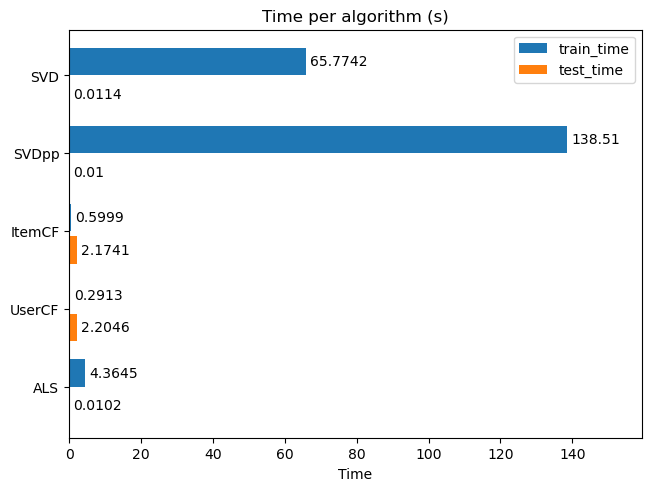

<Figure size 640x480 with 0 Axes>

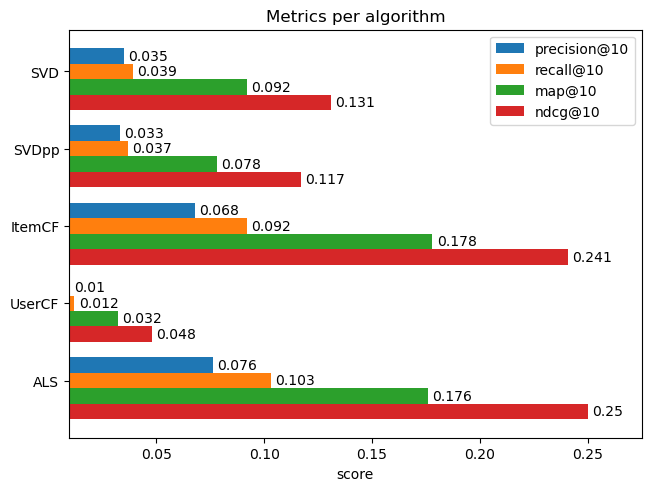

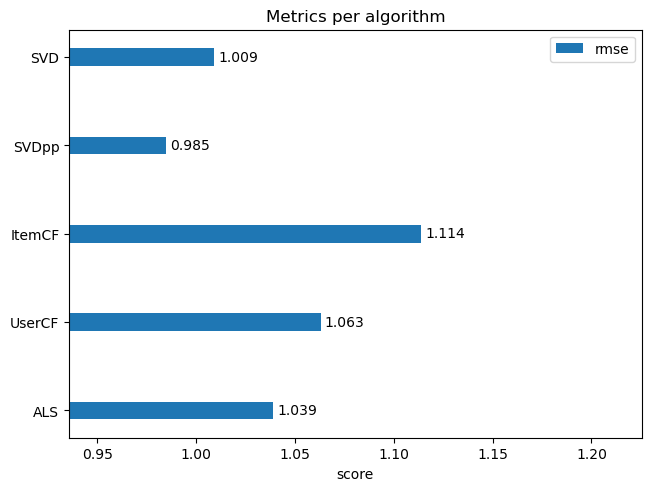

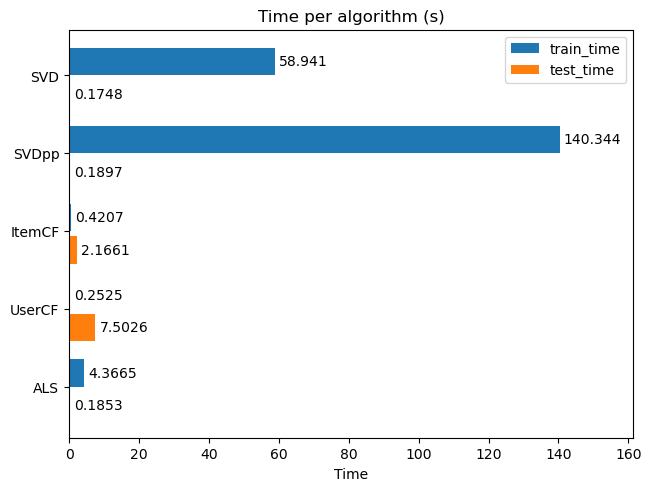

In [112]:
from IPython.display import display
for task in ['rating', 'ranking']:
    model_results_chrono(final_results2[task][0], plot_name=f"plot2_{task}", model_time=True, round_floats=3)
    prameter_dataframe = pd.DataFrame.from_dict(final_results2[task][1]['parameters'], orient='index')
    results_dataframe = pd.DataFrame.from_dict(final_results2[task][0], orient='index').join(prameter_dataframe)
    results_dataframe['total_time'] = results_dataframe['train_time'] + results_dataframe['test_time']
    time_dataframe = results_dataframe[['train_time', 'test_time', 'total_time']]
    
    print(f'{task}:')
    display(prameter_dataframe)
    display(results_dataframe)
    display(time_dataframe)

In [113]:
for task in ['rating', 'ranking']:
    evaluation_dataframe = pd.DataFrame.from_dict(evaluation_results[task], orient='index')
    display(evaluation_dataframe)

,rmse,test_time
SVD,0.989527,0.022336
SVDpp,0.965510,0.021519
ItemCF,1.038134,2.263477
UserCF,1.051074,2.232910
ALS,1.014494,0.008872


,precision,recall,map,ndcg,test_time
SVD,0.032344,0.038741,0.093168,0.126787,0.262153
SVDpp,0.030965,0.037468,0.082995,0.117571,0.190892
ItemCF,0.075928,0.109868,0.191418,0.264037,2.178079
UserCF,0.010498,0.015486,0.024481,0.041523,7.770481
ALS,0.081230,0.109725,0.183020,0.260046,0.195415


In [127]:
import random
from libreco.evaluation.metrics import (LISTWISE_METRICS,
    POINTWISE_METRICS,
    RANKING_METRICS,
    RATING_METRICS,
    average_precision_at_k,
    listwise_scores,
    ndcg_at_k,
    pr_auc_score,
    precision_at_k,
    recall_at_k,
    rmse,
)

def random_baseline_reco(test_data, train_data, all_data, task, metrics: list, k = 10):
    eval_result = {}
    
    if task == 'rating':
        y_true = []
        y_pred = []
        
        for rating in test_data['label']:
            y_true.append(rating)
            
        train_start = t.perf_counter()
        
        for rating in test_data['label']:
            y_pred.append(random.randint(1, 5))
        
        training_time = t.perf_counter() - train_start
        
        test_start = t.perf_counter()
        
        for m in metrics:
            if m not in RATING_METRICS:
                raise Exception(f'Task is set to {task} but no suitable metric was used')
            if m == 'rmse':
                eval_result[m] = rmse(y_true, y_pred)
        test_time = t.perf_counter() - test_start
        
    else:
        y_true = {}
        y_rec = {}
        users = (test_data['user'].unique()).tolist()
        
        for user in users:
            y_true[user] = test_data['item'].loc[test_data['user'] == (user)].tolist()
        
        train_start = t.perf_counter()
        
        for user in users:
            y_rec[user] = all_data['item'].loc[~all_data['item'].isin(train_data['item'].loc[train_data['user'] == user])].sample(n=k)
           
        training_time = t.perf_counter() - train_start
        
        test_start = t.perf_counter()
            
        for m in metrics:
            if m not in LISTWISE_METRICS:
                raise Exception(f'Task is set to {task} but no suitable metric was used')
            if m == "precision":
                fn = precision_at_k
            elif m == "recall":
                fn = recall_at_k
            elif m == "map":
                fn = average_precision_at_k
            elif m == "ndcg":
                fn = ndcg_at_k
            # noinspection PyUnboundLocalVariable
            eval_result[m] = listwise_scores(fn, y_true, y_rec, users, k)
            
        test_time = t.perf_counter() - test_start
        
    eval_result['train_time'] = 0
    eval_result['test_time'] = training_time
            
    return eval_result

def most_frequent_reco(test_data, train_data, task, metrics: list, k = 10):
    
    eval_result = {}
    
    if task == 'rating':
        rating_mode = train_data['label'].mode()[0]
        y_true = []
        y_pred = []
        
        for rating in test_data['label']:
            y_true.append(rating)
            y_pred.append(rating_mode)
            
        
        for m in metrics:
            if m not in RATING_METRICS:
                raise Exception(f'Task is set to {task} but no suitable metric was used')
            if m == 'rmse':
                eval_result[m] = rmse(y_true, y_pred)
    else:
        y_true = {}
        y_rec = {}
        users = (test_data['user'].unique()).tolist()
        
        for user in users:
            y_true[user] = test_data['item'].loc[test_data['user'] == (user)].tolist()
            y_rec[user] = train_data['item'].loc[~train_data['item'].isin(train_data['item'].loc[train_data['user'] == user])].value_counts()[:k].index.tolist()
            
            
        for m in metrics:
            if m not in LISTWISE_METRICS:
                raise Exception(f'Task is set to {task} but no suitable metric was used')
            if m == "precision":
                fn = precision_at_k
            elif m == "recall":
                fn = recall_at_k
            elif m == "map":
                fn = average_precision_at_k
            elif m == "ndcg":
                fn = ndcg_at_k
            # noinspection PyUnboundLocalVariable
            eval_result[m] = listwise_scores(fn, y_true, y_rec, users, k)
            
    eval_result['train_time'] = 0
    eval_result['test_time'] = 0
            
    return eval_result

In [ ]:
# from sklearn.dummy import DummyClassifier

In [128]:
baseline_results = {}

for task in ['rating', 'ranking']:
    
    temp_results = {}

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]

    experiment_data3 = df_data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data3['label'] = df_data['label'].apply(lambda x : 0 if x < 4 else 1)
    else:
        pass
        metrics = metrics_rating

    train, eval, test, = split_by_ratio_chrono(experiment_data3, order=True, multi_ratios=[0.8, 0.1, 0.1])

    
    
    temp_results['random'] = random_baseline_reco(test, train, experiment_data3, task, metrics)
    temp_results['most_frequent'] = most_frequent_reco(test, train, task, metrics)
    
    baseline_results[task] = temp_results

In [ ]:
baseline_results['ranking']

In [ ]:
final_results2['rating'][0]

In [129]:
import copy
final_results3 = copy.deepcopy(final_results2)

final_results3['rating'][0].update(baseline_results['rating'])
final_results3['ranking'][0].update(baseline_results['ranking'])
print(final_results3['rating'][0])

{'SVD': {'rmse': 1.0089564, 'test_time': 0.011444878000020253, 'train_time': 65.77418801999966}, 'SVDpp': {'rmse': 0.98548543, 'test_time': 0.009957485000086308, 'train_time': 138.5101019499998}, 'ItemCF': {'rmse': 1.1141251555857679, 'test_time': 2.174128423000184, 'train_time': 0.5998604910000722}, 'UserCF': {'rmse': 1.0628587353767949, 'test_time': 2.204565960999844, 'train_time': 0.291329080000196}, 'ALS': {'rmse': 1.0392951, 'test_time': 0.010162392999973235, 'train_time': 4.364531310000075}, 'random': {'rmse': 1.8734075917503918, 'train_time': 0, 'test_time': 0.014734556999428605}, 'most_frequent': {'rmse': 1.3815827412978574, 'train_time': 0, 'test_time': 0}}


rating:


,embed_size,n_epochs,lr,reg,sim_type,k_sim
SVD,10.0,50.0,0.003,0.0001,NaN,NaN
SVDpp,20.0,75.0,0.001,0.0002,NaN,NaN
ALS,10.0,50.0,NaN,9.0000,NaN,NaN
ItemCF,NaN,NaN,NaN,NaN,cosine,10.0
UserCF,NaN,NaN,NaN,NaN,cosine,25.0


,rmse,test_time,train_time,embed_size,n_epochs,lr,reg,sim_type,k_sim,total_time
SVD,1.008956,0.011445,65.774188,10.0,50.0,0.003,0.0001,NaN,NaN,65.785633
SVDpp,0.985485,0.009957,138.510102,20.0,75.0,0.001,0.0002,NaN,NaN,138.520059
ItemCF,1.114125,2.174128,0.599860,NaN,NaN,NaN,NaN,cosine,10.0,2.773989
UserCF,1.062859,2.204566,0.291329,NaN,NaN,NaN,NaN,cosine,25.0,2.495895
ALS,1.039295,0.010162,4.364531,10.0,50.0,NaN,9.0000,NaN,NaN,4.374694
random,1.873408,0.014735,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.014735
most_frequent,1.381583,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,train_time,test_time,total_time
SVD,65.774188,0.011445,65.785633
SVDpp,138.510102,0.009957,138.520059
ItemCF,0.599860,2.174128,2.773989
UserCF,0.291329,2.204566,2.495895
ALS,4.364531,0.010162,4.374694
random,0.000000,0.014735,0.014735
most_frequent,0.000000,0.000000,0.000000


ranking:


,embed_size,n_epochs,lr,reg,sim_type,k_sim
SVD,10.0,50.0,0.003,0.0001,NaN,NaN
SVDpp,20.0,75.0,0.001,0.0002,NaN,NaN
ALS,10.0,50.0,NaN,9.0000,NaN,NaN
ItemCF,NaN,NaN,NaN,NaN,cosine,10.0
UserCF,NaN,NaN,NaN,NaN,cosine,25.0


,precision,recall,map,ndcg,test_time,train_time,embed_size,n_epochs,lr,reg,sim_type,k_sim,total_time
SVD,0.035419,0.038580,0.091860,0.131206,0.174811,58.941044,10.0,50.0,0.003,0.0001,NaN,NaN,59.115855
SVDpp,0.032874,0.036860,0.078180,0.116733,0.189706,140.344360,20.0,75.0,0.001,0.0002,NaN,NaN,140.534065
ItemCF,0.068081,0.092073,0.177814,0.240803,2.166108,0.420675,NaN,NaN,NaN,NaN,cosine,10.0,2.586783
UserCF,0.010392,0.011964,0.031605,0.047687,7.502601,0.252513,NaN,NaN,NaN,NaN,cosine,25.0,7.755114
ALS,0.076246,0.103088,0.176369,0.249541,0.185320,4.366521,10.0,50.0,NaN,9.0000,NaN,NaN,4.551841
random,0.019830,0.018544,0.066216,0.107005,3.191510,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.191510
most_frequent,0.059491,0.070492,0.137189,0.201368,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


,train_time,test_time,total_time
SVD,58.941044,0.174811,59.115855
SVDpp,140.344360,0.189706,140.534065
ItemCF,0.420675,2.166108,2.586783
UserCF,0.252513,7.502601,7.755114
ALS,4.366521,0.185320,4.551841
random,0.000000,3.191510,3.191510
most_frequent,0.000000,0.000000,0.000000


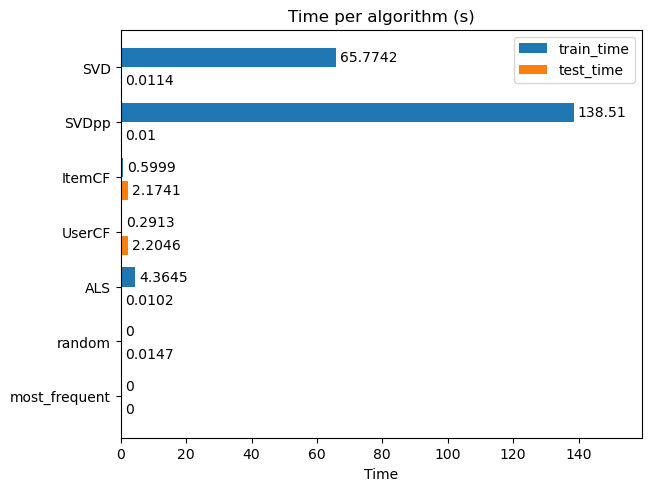

<Figure size 640x480 with 0 Axes>

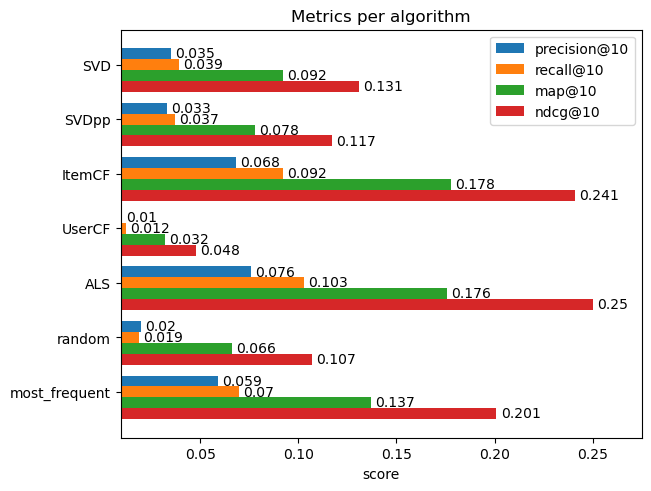

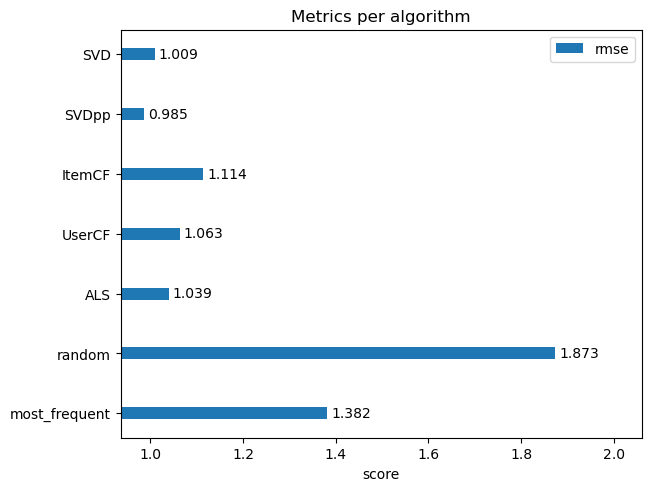

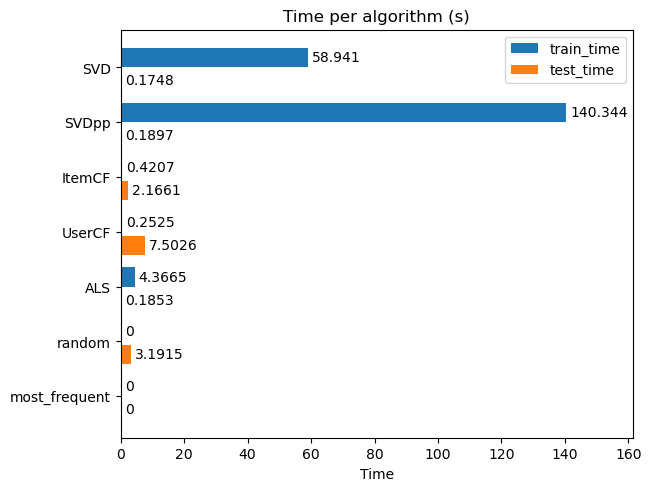

In [130]:
from IPython.display import display
for task in ['rating', 'ranking']:
    model_results_chrono(final_results3[task][0], plot_name=f"plot2_{task}", model_time=True, round_floats=3)
    prameter_dataframe = pd.DataFrame.from_dict(final_results3[task][1]['parameters'], orient='index')
    results_dataframe = pd.DataFrame.from_dict(final_results3[task][0], orient='index').join(prameter_dataframe)
    results_dataframe['total_time'] = results_dataframe['train_time'] + results_dataframe['test_time']
    time_dataframe = results_dataframe[['train_time', 'test_time', 'total_time']]
    
    print(f'{task}:')
    display(prameter_dataframe)
    display(results_dataframe)
    display(time_dataframe)

In [ ]:
import numpy as np
from sklearn.metrics import (
    auc,
    balanced_accuracy_score,
    mean_squared_error,
    precision_recall_curve,
)

RATING_METRICS = {"loss", "rmse", "mae", "r2"}
POINTWISE_METRICS = {"loss", "log_loss", "balanced_accuracy", "roc_auc", "pr_auc"}
LISTWISE_METRICS = {"precision", "recall", "map", "ndcg"}
RANKING_METRICS = POINTWISE_METRICS | LISTWISE_METRICS


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html
def balanced_accuracy(y_true, y_prob):
    y_pred = np.round(y_prob)
    return balanced_accuracy_score(y_true, y_pred)


def pr_auc_score(y_true, y_prob):
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    return auc(recall, precision)


def listwise_scores(fn, y_true_lists, y_reco_lists, users, k):
    scores = list()
    for u in users:
        y_true = y_true_lists[u]
        y_reco = y_reco_lists[u]
        scores.append(fn(y_true, y_reco, k))
    return np.mean(scores)


def precision_at_k(y_true, y_reco, k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / k


def recall_at_k(y_true, y_reco, _k):
    common_items = set(y_reco).intersection(y_true)
    return len(common_items) / len(y_true)


def average_precision_at_k2(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    print(indices_in_reco)
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ap = [np.mean(rank_list[: i + 1]) for i in range(k) if rank_list[i]]
    assert len(ap) == common_items.size, "common size doesn't match..."
    return np.mean(ap)


def ndcg_at_k(y_true, y_reco, k):
    common_items, _, indices_in_reco = np.intersect1d(
        y_true, y_reco, assume_unique=True, return_indices=True
    )
    if common_items.size == 0:
        return 0
    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = 1
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
    idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
    return dcg / idcg

In [ ]:
# from libreco.data import split_by_ratio_chrono
# def create_temporal_splits(data, increments = 10, test_days = 1, stop = None):

#     train_days = data.time.min()
#     day_split = 86400 # day in seconds
#     train_sets = [] # list of train_set datasets
#     test_sets = [] # list of test_sets
#     eval_sets = []
#     temporal_data = [] # keep track of how many days have been trained on.

#     if stop == None:
#         stop = data.time.max()
#     else:
#         stop = train_days + day_split * increments * stop

#     while train_days + day_split * (increments + test_days) <= stop:
#         train_days = train_days + day_split * increments

#         test_set = data.loc[(data['time'] <= train_days + day_split * test_days) & (data['time'] > train_days)]
#         train_set = data.loc[data['time'] <= train_days]

#         test_set = test_set.loc[(test_set['user'].isin(train_set['user'])) & (test_set['item'].isin(train_set['item']))]

#         train_sets.append(train_set)
#         test_sets.append(test_set)

#         temp_time = train_days - df_data.time.min()
#         temporal_data.append(temp_time)
    
#     return train_sets, test_sets, temporal_data

In [ ]:
# def reset_state(name):
#     tf.compat.v1.reset_default_graph()
#     print("\n", "=" * 30, name, "=" * 30)

# def create_results(algos, test_data, metrics):
    
#     results = {}

#     for algo in algos:
#         test_time_start = t.perf_counter()
#         result = evaluate(model=algo, data=test_data, metrics=metrics, neg_sampling=False)
#         result['test_time'] = t.perf_counter() - test_time_start
#         results[algo.__class__.__name__] = result

#     return results

# def run_experiment_final_temp_split(data, preset_parameters, split, temp_split =  save=True, experiment_name = 'default', task = 'ranking', treshold = 4):
#     """Final variant of the experiment, used to quickly run models with pre-optimized settings"""
    
#     if experiment_name == 'default':
#         print('Experiment not named, high possibility for overwrite!')
#     elif os.path.exists(f'/kaggle/working/{experiment_name}'):
#         print('Folder already exists, overwriting models!')
    
#     experiment_details = {}
    

#     metrics_rating = [
#       "rmse"
#     ]

#     metrics_ranking = [
#     "precision",
#     "recall",
#     "map",
#     "ndcg",
#     ]
    
#     experiment_data = data.copy(deep=True)

#     if task == 'ranking':
#         # Change labels to 0,1 as binary "dislike/like"
#         metrics = metrics_ranking
#         experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
#     else:
#         metrics = metrics_rating
        
#     experiment_details['metrics'] = metrics
    
#     if len(split) == 3:
#         print(f'Split contains 3 values, combining values:')
#         split = [split[0], split[1] + split[2]]
#         print(f'New split: {split}')
#         train, test, = split_by_ratio_chrono(experiment_data, order=True, test_size=split[1])

#     train_data, data_info = DatasetPure.build_trainset(train)

#     test_data = DatasetPure.build_testset(test)

#     svd_params = preset_parameters['svd']

#     start = t.perf_counter()

#     reset_state("SVD")
#     svd = SVD(
#         task,
#         data_info,
#         embed_size=svd_params['embed_size'],
#         n_epochs=svd_params['n_epochs'],
#         lr=svd_params['lr'],
#         reg=svd_params['reg'],
#     )

#     svd.fit(
#         train_data,
#         verbose=0,
#         shuffle=False,
#         neg_sampling=False
#     )

#     svd_time = t.perf_counter() - start

#     svdpp_params = preset_parameters['svdpp']

#     start = t.perf_counter()

#     reset_state("SVD++")
#     svdpp = SVDpp(
#         task,
#         data_info,
#         loss_type="cross_entropy",
#         embed_size=svdpp_params['embed_size'],
#         n_epochs=svdpp_params['n_epochs'],
#         lr=svdpp_params['lr'],
#         reg=svdpp_params['reg'],
#     )

#     svdpp.fit(
#         train_data,
#         verbose=0,
#         neg_sampling=False,
#     )

#     svdpp_time = t.perf_counter() - start

#     item_cf_params = preset_parameters['item_cf']

#     start = t.perf_counter()

#     reset_state("item_cf")
#     item_cf = ItemCF(
#         task,
#         data_info=data_info,
#         k_sim=item_cf_params['k_sim'],
#         sim_type=item_cf_params['sim_type'],
#     )

#     item_cf.fit(
#         train_data,
#         verbose=0,
#         neg_sampling=False,
#     )

#     item_cf_time = t.perf_counter() - start

#     user_cf_params = preset_parameters['user_cf']

#     start = t.perf_counter()

#     reset_state("user_cf")
#     user_cf = UserCF(
#         task,
#         data_info=data_info,
#         k_sim=user_cf_params['k_sim'],
#         sim_type=user_cf_params['sim_type'],
#     )

#     user_cf.fit(
#         train_data,
#         verbose=0,
#         neg_sampling=False,
#     )

#     user_cf_time = t.perf_counter() - start

#     als_params = preset_parameters['als']

#     start = t.perf_counter()

#     reset_state("ALS")
#     als = ALS(
#         task,
#         data_info,
#         embed_size=als_params['embed_size'],
#         n_epochs=als_params['n_epochs'],
#         reg=als_params['reg']
#     )

#     als.fit(
#         train_data,
#         verbose=0,
#         neg_sampling=False
#     )

#     als_time = t.perf_counter() - start
    
#     parameters = [('SVD', svd_params), ('SVDpp',svdpp_params), ('ItemCF', item_cf_params), ('UserCF',user_cf_params), ('ALS', als_params)]

#     timers = [('SVD', svd_time), ('SVDpp',svdpp_time), ('ItemCF', item_cf_time), ('UserCF',user_cf_time), ('ALS',als_time)]

#     algos = [svd, svdpp, item_cf, user_cf, als]

#     results = create_results(algos, test_data, metrics)
    
#     if save:
#         for algo in algos:
#             algo.save(
#                 path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
#                 model_name=algo.__class__.__name__, 
#                 manual=True, 
#                 inference_only=False
#             )

#     for times in timers:
#         results[times[0]]['train_time'] = times[1]

    
#     algo_parameters = {}
#     for parameter_set in parameters:
#         algo_parameters[parameter_set[0]] = parameter_set[1]
        
#     experiment_details['parameters'] = algo_parameters


#     return results, experiment_details


In [ ]:
# day_40 = df_data['time'].min() + 86400 * 90

# describe_set = df_data.loc[(df_data['time'] > day_40) & (df_data['time'] < day_40 + 86400)]['label'].describe()

# describe_set

In [ ]:
# df_data['label'].value_counts()

In [ ]:
# for desc in ['count', 'mean', 'std', '75%']:
#   value_list = []
#   value_list2 = []
#   day_list = list(range(0, 210, 10))
#   for day in range(0, 210, 10):
#     day_m = df_data['time'].min() + 86400 * day
#     value_list.append(df_data.loc[(df_data['time'] > day_m) & (df_data['time'] < day_m + 86400)]['label'].describe()[desc])
#     value_list2.append(df_data.loc[(df_data['time'] <= day_m)]['label'].describe()[desc])

#   plt.figure(figsize=(10,6))

#   fig, ax = plt.subplots()

#   ax.plot(day_list, value_list, label=f'{desc}')
#   ax.plot(day_list, value_list2, label=f'time_before')

#   ax.set(xlabel='time (d)', ylabel=f'{desc}',
#         title=f'Comparison for {desc}')
#   ax.grid()
#   ax.set_xticks((range(10, 210, 20)))

#   # fig.savefig("test.png")
#   plt.legend()
#   plt.show()

In [ ]:
# test_run4['40']

In [ ]:
# train_data, eval_data, test_data = random_split(df_data, multi_ratios=[0.8, 0.1, 0.1])
# eval_data = DatasetPure.build_evalset(eval_data)
# train_data, data_info = DatasetPure.build_trainset(train)
# test_data = DatasetPure.build_testset(test)

# def reset_state(name):
#     tf.compat.v1.reset_default_graph()
#     print("\n", "=" * 30, name, "=" * 30)

# def create_results(algos, test_data, metrics):

#   results = {}

#   for algo in algos:
#     print(algo)
#     result = evaluate(model=algo, data=test_data, metrics=metrics, k=20)
#     results[algo.__class__.__name__] = result

#   return results

# metrics = [
#   "precision",
#   "recall",
#   "map",
#   "ndcg",
# ]

# reset_state("SVD")
# svd = SVD(
#     "ranking",
#     data_info,
#     embed_size=20,
#     n_epochs=50,
#     lr=0.001,
#     reg=0.0001,
# )

# svd.fit(
#     train_data,
#     verbose=0,
#     shuffle=False,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("SVD++")
# svdpp = SVDpp(
#     "ranking",
#     data_info,
#     loss_type="cross_entropy",
#     embed_size=50,
#     n_epochs=25,
#     lr=0.001,
#     reg=0.0001,
# )

# svdpp.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("item_cf")
# item_cf = ItemCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=25,
#     sim_type="pearson",
# )

# item_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("user_cf")
# user_cf = UserCF(
#     task="ranking",
#     data_info=data_info,
#     k_sim=50,
#     sim_type="pearson",
# )

# user_cf.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# reset_state("ALS")
# als = ALS(
#     "ranking",
#     data_info,
#     embed_size=10,
#     n_epochs=200,
#     reg=5.0
# )

# als.fit(
#     train_data,
#     verbose=0,
#     # eval_data=eval_data,
#     # metrics=metrics,
# )

# algos = [svd, svdpp, als, item_cf, user_cf]

# result = create_results(algos, test_data, metrics)

# print(result)

In [ ]:
# test_figures4 = model_results(test_run4, metrics_ranking, 2, model_time=True)

In [ ]:
# for algorithm, algo_values in result.items():
#   for metric, values in algo_values.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# species = ("Adelie", "Chinstrap", "Gentoo")
# penguin_means = {
#     'Bill Depth': (18.35, 18.43, 14.98),
#     'Bill Length': (38.79, 48.83, 47.50),
#     'Flipper Length': (189.95, 195.82, 217.19),
# }

# x = np.arange(len(species))  # the label locations
# width = 0.25  # the width of the bars
# multiplier = 0

# fig, ax = plt.subplots(layout='constrained')

# for attribute, measurement in penguin_means.items():
#     offset = width * multiplier
#     rects = ax.bar(x + offset, measurement, width, label=attribute)
#     ax.bar_label(rects, padding=3)
#     multiplier += 1

# # Add some text for labels, title and custom x-axis tick labels, etc.
# ax.set_ylabel('Length (mm)')
# ax.set_title('Penguin attributes by species')
# ax.set_xticks(x + width, species)
# ax.legend(loc='upper left', ncols=3)
# ax.set_ylim(0, 250)

# plt.show()

In [ ]:
# result

In [ ]:
# svd.__class__.__name__

In [ ]:
# algos = [svd, svdpp, item_cf, user_cf, als]

# results = {}

# for algo in algos:
#   accuracy = evaluate(model=algo, data=test_data, metrics=metrics)
#   results[algo.__class__.__name__] = accuracy

In [ ]:
# print(results)

In [ ]:
df_data.head()

In [ ]:
train_time22 = []
test_time22 = []
experimental_data2 = df_data.copy(deep=True)
experimental_data2['label'] = df_data['label'].apply(lambda x : 0 if x < 4 else 1)

train22, eval22, test22 = split_by_ratio_chrono(experimental_data2, order=True, multi_ratios=[0.8, 0.1, 0.1])

train_data22, data_info22 = DatasetPure.build_trainset(train22)

test_data22 = DatasetPure.build_testset(test22)

eval_data22 = DatasetPure.build_evalset(eval22)

for epoch in [50, 100, 150, 200]:
    tf.compat.v1.reset_default_graph()

    metrics = [
      "precision",
      "recall",
      "map",
      "ndcg",
    ]

    als = ALS(
        "ranking",
        data_info22,
        reg=5.0,
        embed_size=20,
        n_epochs=epoch,
    #     lr=0.001,
    #     reg=0.0001,
    )

    als_train_start22 = t.perf_counter()

    als.fit(
        train_data22,
        verbose=0,
        eval_data=eval_data22,
        metrics=metrics,
        neg_sampling=False,
    )

    als_train_time22 = t.perf_counter() - als_train_start22

    als_test_start22 = t.perf_counter()

    accuracy = evaluate(model=als, data=test_data22, metrics=metrics, neg_sampling=False)

    als_test_time22 = t.perf_counter()
    
    train_time22.append(als_train_time22)
    test_time22.append(als_test_time22)


In [ ]:
fig, ax = plt.subplots()

epochs = [50, 100, 150, 200]

ax.plot(epochs, train_time22, linewidth = 2.0, label='train time')

ax.set_xlabel('Epochs')
ax.set_ylabel('Time')

plt.legend()

fig.savefig(f"als_train_time.png")

plt.show()


In [ ]:
fig, ax = plt.subplots()
epochs = [50, 100, 150, 200]
ax.set_xlabel('Epochs')
ax.set_ylabel('Time')

ax.plot(epochs, test_time22, linewidth = 2.0, label='test time')
ax.set_xlabel('Epochs')
ax.set_ylabel('Time')
plt.legend()

fig.savefig(f"als_test_time.png")

plt.show()


In [108]:
experimental_data2 = df_data.copy(deep=True)
# experimental_data2['label'] = df_data['label'].apply(lambda x : 0 if x < 4 else 1)

ratings_per_item = experimental_data2['item'].value_counts()
ratings_per_user = experimental_data2['user'].value_counts()

filtered_df = experimental_data2.loc[~experimental_data2['user'].isin(ratings_per_user.loc[ratings_per_user < 80])]

train22, eval22, test22 = split_by_ratio_chrono(filtered_df, order=True, multi_ratios=[0.8, 0.1, 0.1])

train_data22, data_info22 = DatasetPure.build_trainset(train22)

test_data22 = DatasetPure.build_testset(test22)

eval_data22 = DatasetPure.build_evalset(eval22)

tf.compat.v1.reset_default_graph()

metrics = [
  "precision",
  "recall",
  "map",
  "ndcg",
]

als = ALS(
    "rating",
    data_info22,
    reg = 5.0,
    embed_size=20,
    n_epochs=25,
#     lr=0.001,
#     reg=0.0001,
)

# als_train_start22 = t.perf_counter()

als.fit(
    train_data22,
    verbose=0,
    eval_data=eval_data22,
#     metrics='rmse',
    neg_sampling=False,
)

# accuracy = evaluate(model=als, data=test_data22, metrics=metrics, neg_sampling=False)

Training start time: 2023-05-01 14:05:45


In [109]:
# {'precision': 0.0653234358430541,
#  'recall': 0.11751162351695228,
#  'map': 0.1620717132631946,
#  'ndcg': 0.22963145307498484}

test_eval33 = evaluate(model=als, data=test_data22, metrics=['rmse'], neg_sampling=False)

test_eval33

eval_pointwise: 100%|██████████| 2/2 [00:00<00:00, 463.84it/s]


{'rmse': 1.0635674}

In [ ]:
from libreco.evaluation.computation

y_preds, y_true = compute_preds(als, test_data22, 256)

print(y_true)

In [96]:
als.recommend_user(1, 10)

{1: array([ 543, 1098,  664,  818, 1136, 1286,  962, 1159, 1160,  955])}

In [91]:
from libreco.evaluation.computation import (
    build_eval_transformed_data,
    compute_preds,
    compute_probs,
    compute_recommends,
)

from libreco.evaluation.evaluate import sample_users
from tqdm import tqdm
import math

# TODO: Maak een list met items, maak net zoals bij compute_recommends een lijst van predictions per user zodat deze in de custom ndcg functie kan.
def compute_recommends_custom(model, users, k, num_batch_users):
    y_recommends = dict()
    for i in tqdm(range(0, len(users), num_batch_users), desc="eval_listwise"):
        batch_users = users[i: i + num_batch_users]
        batch_recs = model.recommend_user(
            user=batch_users,
            n_rec=k,
            inner_id=True,
            filter_consumed=True,
            random_rec=False,
        )
        y_recommends.update(batch_recs)
    return y_recommends
    

def custom_ndcg(model, data, seed = 42, sample_user_num = None, eval_batch_size = 8192, k = 10):
    users = sample_users(data, seed, sample_user_num)
    num_batch_users = max(1, math.floor(eval_batch_size / model.n_items))
    y_recos = compute_recommends_custom(model, users, k, num_batch_users)
    
    scores = list()

    for user in users:
        items = y_recos[user]
        consumed_items = [rel[1] for rel in data if rel[0] == user]
        true_labels = np.array([rel[2] for rel in data if rel[0] == user])

        common_items, indices_in_true, indices_in_reco = np.intersect1d(
            consumed_items, items, assume_unique=True, return_indices=True
        )

        if common_items.size == 0:
            scores.append(0)
        else:
            rank_list = np.zeros(k, np.float32)
            print(true_labels[indices_in_true])
            rank_list[indices_in_reco] = 1
            ideal_list = np.sort(rank_list)[::-1]
            dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
            idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
            ndcg = dcg / idcg
            scores.append(ndcg)

    return np.mean(scores)

In [ ]:
u, i, label = test_data22[:10]

print(u, i, label)

In [89]:
test_list33 = (compute_recommends_custom(als, [0, 1, 2, 3, 4, 5], 10, 10))

test_list33

eval_listwise: 100%|██████████| 1/1 [00:00<00:00, 456.70it/s]


{0: array([ 407,  168,  188,  557,  987,  914, 1067,  712,  651,  528]),
 1: array([  8, 123, 320, 470, 125, 590, 332, 303, 299,  14]),
 2: array([345, 269, 750, 346, 314, 749, 311, 893, 309, 877]),
 3: array([753, 689, 267, 285, 305, 301, 268, 293, 332, 244]),
 4: array([1103,   71,   90,   87,  566,  624,   66,  201,  674,    7]),
 5: array([606, 603, 660, 133, 653, 251, 254, 704, 180, 843])}

In [93]:
als.get_item_embedding(1)

array([ 0.03754378,  0.0592435 ,  0.02024628, -0.02134505, -0.02403623,
        0.0127277 , -0.06393906,  0.07466002,  0.04771014,  0.1134239 ,
       -0.01187663, -0.01603073,  0.03462921,  0.02713365, -0.00958816,
        0.04435691,  0.03816153, -0.00020905, -0.0147209 , -0.06331113],
      dtype=float32)

In [92]:
test_ndcg = custom_ndcg(als, test_data22)

eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1396.27it/s]


[1. 1.]
[1.]
[1.]
[1.]


IndexError: index -37 is out of bounds for axis 0 with size 10

In [ ]:
print(test_ndcg)

In [98]:
test_eval33 = evaluate(model=als, data=test_data22, metrics=['map'], neg_sampling=False)

test_eval33

ValueError: Metrics `map` is not suitable for rating task...

In [ ]:
test22.loc[test22['user'] == 1]

In [ ]:
true_labels = dict()

users33 = [0]

for user in users33:
    item_true_labels = list()
    items = test_list33[user]
    consumed_items = [rel[1] for rel in test_data22 if rel[0] == user]
    true_labels = [rel[2] for rel in test_data22 if rel[0] == user]
    
    common_items, indices_in_true, indices_in_reco = np.intersect1d(
        consumed_items, items, assume_unique=True, return_indices=True
    )
    
    if common_items.size == 0:
        return 0

    rank_list = np.zeros(k, np.float32)
    rank_list[indices_in_reco] = true_labels[indices_in_true]
    ideal_list = np.sort(rank_list)[::-1]
    dcg = np.sum(rank_list / np.log2(np.arange(2, k + 2)))
    idcg = np.sum(ideal_list / np.log2(np.arange(2, k + 2)))
    return dcg / idcg
    

In [ ]:
previous_recommend = {1: [ 543, 1098,  664,  818, 1136, 1286,  962, 1159, 1160,  955]}

# {1: array([515, 475, 100, 462, 531, 582, 509, 431, 403, 405])}

In [ ]:
print(dir(als))

In [ ]:
print(als_train_time22)

In [ ]:
print(accuracy)

In [133]:
def reset_state(name):
    tf.compat.v1.reset_default_graph()
    print("\n", "=" * 30, name, "=" * 30)

def create_results(algos, test_data, metrics, k = 10):
    
    results = {}

    for algo in algos:
        test_time_start = t.perf_counter()
        result = evaluate(model=algo, data=test_data, metrics=metrics, k=k, neg_sampling=False)
        result['test_time'] = t.perf_counter() - test_time_start
        results[algo.__class__.__name__] = result

    return results

def run_experiment_als_itemcf(data, preset_parameters, split, save=True, experiment_name = 'default', k = 10, task = 'ranking', treshold = 4):
    """Final variant of the experiment, used to quickly run models with pre-optimized settings"""
    
    if experiment_name == 'default':
        print('Experiment not named, high possibility for overwrite!')
    elif os.path.exists(f'/kaggle/working/{experiment_name}'):
        print('Folder already exists, overwriting models!')
    
    experiment_details = {}
    

    metrics_rating = [
      "rmse"
    ]

    metrics_ranking = [
    "precision",
    "recall",
    "map",
    "ndcg",
    ]
    
    experiment_data = data.copy(deep=True)

    if task == 'ranking':
        # Change labels to 0,1 as binary "dislike/like"
        metrics = metrics_ranking
        experiment_data['label'] = data['label'].apply(lambda x : 0 if x < treshold else 1)
    else:
        metrics = metrics_rating
        
    experiment_details['metrics'] = metrics
    
    train, eval, test, = split_by_ratio_chrono(experiment_data, order=True, multi_ratios=split)

    train_data, data_info = DatasetPure.build_trainset(train)
    
    eval_data = DatasetPure.build_evalset(eval)

    test_data = DatasetPure.build_testset(test)


    item_cf_params = preset_parameters['item_cf']

    start = t.perf_counter()

    reset_state("item_cf")
    item_cf = ItemCF(
        task,
        data_info=data_info,
        k_sim=item_cf_params['k_sim'],
        sim_type=item_cf_params['sim_type'],
    )

    item_cf.fit(
        train_data,
        verbose=0,
        neg_sampling=False,
    )

    item_cf_time = t.perf_counter() - start

    als_params = preset_parameters['als']

    start = t.perf_counter()

    reset_state("ALS")
    als = ALS(
        task,
        data_info,
        embed_size=als_params['embed_size'],
        n_epochs=als_params['n_epochs'],
        reg=als_params['reg']
    )

    als.fit(
        train_data,
        verbose=0,
        neg_sampling=False
    )

    als_time = t.perf_counter() - start
    

    timers =[('ItemCF', item_cf_time), ('ALS',als_time)]

    algos = [item_cf, als]
    
    eval_results = create_results(algos, eval_data, metrics, k=k)

    results = create_results(algos, test_data, metrics, k=k)
    
    if save:
        for algo in algos:
            algo.save(
                path=f"/kaggle/working/{experiment_name}/{algo.__class__.__name__}", 
                model_name=algo.__class__.__name__, 
                manual=True, 
                inference_only=False
            )

    for times in timers:
        results[times[0]]['train_time'] = times[1]


    return results, eval_results, experiment_details


In [190]:
als_itemcf_results = {}
evaluation_results = {}
for k in range(5, 50, 5):
    final_experiment, evaluation_results[k], details = run_experiment_als_itemcf(df_data, 
                                           preset_parameters = preset_parameters, 
                                           save=False, 
                                           experiment_name=f'als_itemCF{k}', 
                                           split=[0.8, 0.1, 0.1], 
                                           task='ranking', 
                                           k=k,)
    als_itemcf_results[k] = (final_experiment, details)


 ============================== item_cf ==============================
Training start time: 2023-05-01 15:58:09
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.089s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8399.07it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:58:09


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1258.49it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:58:21
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.111s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 6999.48it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:58:22


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1272.14it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:58:35
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.104s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 5892.59it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:58:35


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1476.51it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:58:49
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.085s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8390.87it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:58:49


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1465.04it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:58:59
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.088s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8575.06it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:59:00


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1454.43it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:59:10
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.085s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8542.78it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:59:10


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1466.81it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:59:20
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.086s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8453.26it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:59:21


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1428.44it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:59:30
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.089s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8469.60it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:59:31


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1377.06it/s]



 ============================== item_cf ==============================
Training start time: 2023-05-01 15:59:42
Final block size and num: (1613, 1)
sim_matrix elapsed: 0.087s
sim_matrix, shape: (1613, 1613), num_elements: 730078, density: 82.1005 %


top_k: 100%|██████████| 1613/1613 [00:00<00:00, 8301.23it/s]



 ============================== ALS ==============================
Training start time: 2023-05-01 15:59:42


eval_listwise: 100%|██████████| 189/189 [00:00<00:00, 1371.63it/s]


In [135]:
als_itemcf_results

{10: ({'ItemCF': {'precision': 0.06808059384941675,
    'recall': 0.09207343795801469,
    'map': 0.1778138051656878,
    'ndcg': 0.2408031075757461,
    'test_time': 2.3244950289999906,
    'train_time': 0.34714483999960066},
   'ALS': {'precision': 0.07624602332979852,
    'recall': 0.10308832120941142,
    'map': 0.1763685129559179,
    'ndcg': 0.2495408498608332,
    'test_time': 0.2010585779999019,
    'train_time': 5.222209330999249}},
  {'metrics': ['precision', 'recall', 'map', 'ndcg']}),
 15: ({'ItemCF': {'precision': 0.06101095793566631,
    'recall': 0.12169071806594349,
    'map': 0.17119907382342367,
    'ndcg': 0.25627032511063125,
    'test_time': 2.2393859210005758,
    'train_time': 0.38094714999988355},
   'ALS': {'precision': 0.06899964651820431,
    'recall': 0.13892902372737312,
    'map': 0.17288694013214315,
    'ndcg': 0.2700641909656654,
    'test_time': 0.21056321200012462,
    'train_time': 4.507063170999572}},
  {'metrics': ['precision', 'recall', 'map', 'nd

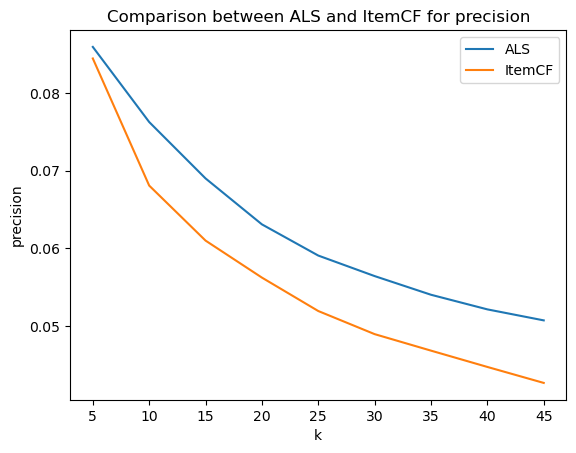

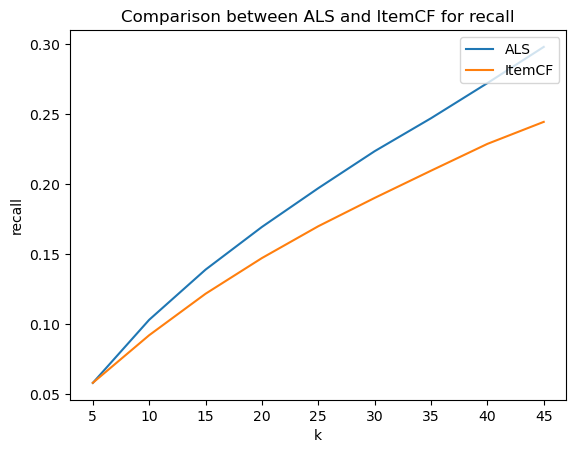

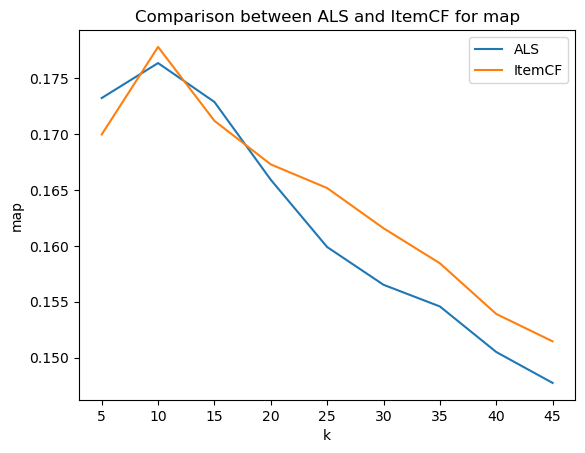

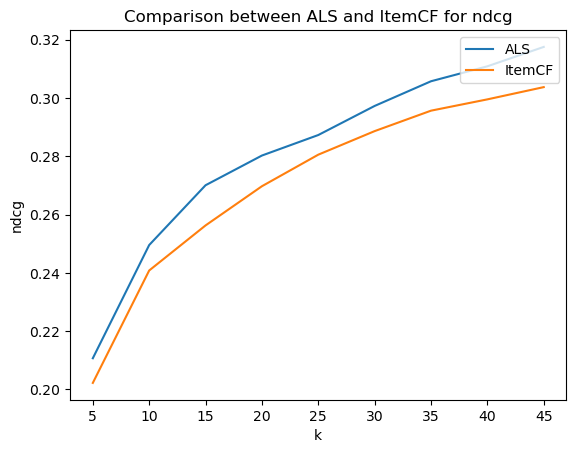

In [191]:
k_list = range(5, 50, 5)

for metric in ['precision', 'recall', 'map', 'ndcg']:
    fig, ax = plt.subplots()
    als_values = list()
    item_cf_values = list()
    for k in k_list:
        als_values.append(als_itemcf_results[k][0]['ALS'][metric])
        item_cf_values.append(als_itemcf_results[k][0]['ItemCF'][metric])
        
    ax.plot(k_list, als_values, label='ALS')
    ax.plot(k_list, item_cf_values, label='ItemCF')
    
    ax.set_xlabel('k')
    ax.set_ylabel(metric)
    
    ax.legend(loc='upper right')
    
    ax.set_title(f'Comparison between ALS and ItemCF for {metric}')
    
    plt.show()

In [ ]:
from IPython.display import display
for task in ['rating', 'ranking']:
    model_results_chrono(final_results3[task][0], plot_name=f"plot2_{task}", model_time=True, round_floats=3)
    prameter_dataframe = pd.DataFrame.from_dict(final_results3[task][1]['parameters'], orient='index')
    results_dataframe = pd.DataFrame.from_dict(final_results3[task][0], orient='index').join(prameter_dataframe)
    results_dataframe['total_time'] = results_dataframe['train_time'] + results_dataframe['test_time']
    time_dataframe = results_dataframe[['train_time', 'test_time', 'total_time']]
    
    print(f'{task}:')
    display(prameter_dataframe)
    display(results_dataframe)
    display(time_dataframe)